In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


PSO

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.random import rand
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def Fun(xtrain, ytrain, features, opts):
    selected_features = np.where(features == 1)[0]
    if len(selected_features) == 0:
        return 1.0  # High error if no features are selected

    xtrain_subset = xtrain[:, selected_features]
    model = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5, class_weight="balanced", random_state=42)
    min_class_count = min(np.bincount(ytrain))
    cv_splits = min(5, min_class_count)
    accuracy = cross_val_score(model, xtrain_subset, ytrain, cv=StratifiedKFold(n_splits=cv_splits, shuffle=True), scoring='accuracy')

    return 1 - np.mean(accuracy)  # Minimize error (1 - accuracy)

def binary_conversion(X, thres, N, dim):
    binary_X = (X > thres).astype(int)
    for i in range(N):
        selected_indices = np.where(binary_X[i] == 1)[0]
        target_features = max(1, int(dim * 0.05))
        if len(selected_indices) > target_features:
            chosen_indices = np.random.choice(selected_indices, target_features, replace=False)
            binary_X[i] = np.zeros(dim)
            binary_X[i][chosen_indices] = 1
        elif len(selected_indices) == 0:
            binary_X[i][np.random.randint(0, dim)] = 1
    return binary_X

def feature_importance_filter(X, y, selected_indices):
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X, y)
    importances = model.feature_importances_
    ranked_features = np.argsort(importances)[::-1]
    max_features = max(1, int(len(ranked_features) * 0.05))
    return [f for f in selected_indices if f in ranked_features[:max_features]]

def jfs(xtrain, ytrain, opts):
    ub, lb, thres = 1, 0, 0.95
    w, c1, c2 = 0.9, 2, 2
    N, max_iter = opts['N'], opts['T']
    dim = xtrain.shape[1]
    lb, ub = np.full((1, dim), lb), np.full((1, dim), ub)
    X = lb + (ub - lb) * rand(N, dim)
    V = -1 + 2 * rand(N, dim)
    fit = np.zeros(N)
    Xgb, fitG = np.zeros(dim), float('inf')
    Xpb, fitP = np.zeros((N, dim)), np.full(N, float('inf'))
    curve = np.zeros(max_iter)

    for t in range(max_iter):
        Xbin = binary_conversion(X, thres, N, dim)
        for i in range(N):
            fit[i] = Fun(xtrain, ytrain, Xbin[i], opts)
            if fit[i] < fitP[i]:
                Xpb[i], fitP[i] = X[i].copy(), fit[i]
            if fitP[i] < fitG:
                Xgb, fitG = Xpb[i].copy(), fitP[i]
        curve[t] = fitG
        for i in range(N):
            r1, r2 = rand(), rand()
            V[i] = w * V[i] + c1 * r1 * (Xpb[i] - X[i]) + c2 * r2 * (Xgb - X[i])
            X[i] = np.clip(X[i] + V[i], lb, ub)

    Gbin = binary_conversion(Xgb.reshape(1, -1), thres, 1, dim).reshape(dim)
    sel_index = np.where(Gbin == 1)[0]
    refined_selection = feature_importance_filter(xtrain, ytrain, sel_index)

    return {'sf': refined_selection, 'c': curve, 'nf': len(refined_selection)}

if __name__ == "__main__":
    data = pd.read_csv("/content/drive/MyDrive/Lymphoma.csv")
    X, y = data.iloc[:, :-1].values, data.iloc[:, -1].values
    y = LabelEncoder().fit_transform(y)
    X = SimpleImputer(strategy="mean").fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    opts = {'N': 30, 'T': 20}
    pso_result = jfs(X_train, y_train, opts)
    selected_indices = pso_result['sf']
    X_train_selected, X_test_selected = X_train[:, selected_indices], X_test[:, selected_indices]
    model = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5, class_weight="balanced", random_state=42)
    model.fit(X_train_selected, y_train)
    accuracy = np.mean(cross_val_score(model, X_test_selected, y_test, cv=StratifiedKFold(n_splits=5), scoring='accuracy'))
    reduction_percentage = ((X.shape[1] - len(selected_indices)) / X.shape[1]) * 100
    print("Total Features:", X.shape[1])
    print("Selected Features:", selected_indices)
    print("Number of Selected Features:", pso_result['nf'])
    print("Feature Reduction Percentage:", reduction_percentage)
    print("Accuracy of selecting features:", accuracy)
    def evaluate_model(model, X_test, y_test):
        y_pred = model.predict(X_test)
        metrics = {
            'Overall Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred, average='macro', zero_division=1),
            'Recall': recall_score(y_test, y_pred, average='macro', zero_division=1),
            'F1 Score': f1_score(y_test, y_pred, average='macro', zero_division=1),
        }
        for key, value in metrics.items():
            print(f"{key}: {value:.4f}")
    evaluate_model(model, X_test_selected, y_test)

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Total Features: 4026
Selected Features: [np.int64(714), np.int64(953), np.int64(1266), np.int64(2038), np.int64(2120), np.int64(2904), np.int64(3228)]
Number of Selected Features: 7
Feature Reduction Percentage: 99.826130153999
Accuracy of selecting features: 0.7
Overall Accuracy: 0.8500
Precision: 0.8077
Recall: 0.8413
F1 Score: 0.8201


PSO with balance (Improved Accuracy)

In [ ]:
import numpy as np
from numpy.random import rand
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import pandas as pd
from collections import Counter
import warnings

warnings.simplefilter(action='ignore', category=UserWarning)

def get_safe_n_splits(y, max_splits=5):
    class_counts = Counter(y)
    return min(max_splits, min(class_counts.values()))

def Fun(xtrain, ytrain, features, opts):
    selected_features = np.where(features == 1)[0]
    if len(selected_features) == 0:
        return 1.0

    xtrain_subset = xtrain[:, selected_features]
    model = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5, class_weight="balanced", random_state=42)

    n_splits = get_safe_n_splits(ytrain, max_splits=5)
    accuracy = cross_val_score(model, xtrain_subset, ytrain, cv=StratifiedKFold(n_splits=n_splits), scoring='accuracy')

    return 1 - np.mean(accuracy)

def binary_conversion(X, thres, N, dim):
    binary_X = (X > thres).astype(int)
    min_features = max(1, int(dim * 0.03))
    max_features = max(1, int(dim * 0.07))

    for i in range(N):
        selected_indices = np.where(binary_X[i] == 1)[0]
        if len(selected_indices) > max_features:
            chosen_indices = np.random.choice(selected_indices, max_features, replace=False)
            binary_X[i] = np.zeros(dim)
            binary_X[i][chosen_indices] = 1
        elif len(selected_indices) < min_features:
            additional_indices = np.random.choice(np.where(binary_X[i] == 0)[0], min_features - len(selected_indices), replace=False)
            binary_X[i][additional_indices] = 1

    return binary_X

def feature_importance_filter(X, y, selected_indices, reduction_ratio=0.05):
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X, y)
    importances = model.feature_importances_
    ranked_features = np.argsort(importances)[::-1]
    max_features = max(1, int(len(ranked_features) * reduction_ratio))
    top_features = ranked_features[:max_features]

    refined_selection = [f for f in selected_indices if f in top_features]
    if len(refined_selection) < 1:
        refined_selection = top_features[:min(10, len(top_features))]

    return refined_selection

def jfs(xtrain, ytrain, opts):
    ub, lb, thres = 1, 0, 0.95
    w, c1, c2 = 0.9, 2, 2
    N, max_iter = opts['N'], opts['T']

    dim = xtrain.shape[1]
    lb, ub = np.full((1, dim), lb), np.full((1, dim), ub)
    X = lb + (ub - lb) * rand(N, dim)
    V = -1 + 2 * rand(N, dim)

    fit = np.zeros(N)
    Xgb, fitG = np.zeros(dim), float('inf')
    Xpb, fitP = np.zeros((N, dim)), np.full(N, float('inf'))
    curve = np.zeros(max_iter)

    for t in range(max_iter):
        Xbin = binary_conversion(X, thres, N, dim)
        for i in range(N):
            fit[i] = Fun(xtrain, ytrain, Xbin[i], opts)
            if fit[i] < fitP[i]:
                Xpb[i], fitP[i] = X[i].copy(), fit[i]
            if fitP[i] < fitG:
                Xgb, fitG = Xpb[i].copy(), fitP[i]

        curve[t] = fitG
        for i in range(N):
            r1, r2 = rand(), rand()
            V[i] = w * V[i] + c1 * r1 * (Xpb[i] - X[i]) + c2 * r2 * (Xgb - X[i])
            X[i] = np.clip(X[i] + V[i], lb, ub)

    Gbin = binary_conversion(Xgb.reshape(1, -1), thres, 1, dim).reshape(dim)
    sel_index = np.where(Gbin == 1)[0]
    refined_selection = feature_importance_filter(xtrain, ytrain, sel_index, reduction_ratio=0.05)

    return {'sf': refined_selection, 'c': curve, 'nf': len(refined_selection)}

if __name__ == "__main__":
    data = pd.read_csv("/content/drive/MyDrive/Lymphoma.csv")
    X, y = data.iloc[:, :-1].values, data.iloc[:, -1].values
    X = SimpleImputer(strategy="mean").fit_transform(X)

    sm = SMOTE(random_state=42)
    X_resampled, y_resampled = sm.fit_resample(X, y)

    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled)

    opts = {'N': 30, 'T': 20}
    pso_result = jfs(X_train, y_train, opts)

    selected_indices = pso_result['sf']
    X_train_selected, X_test_selected = X_train[:, selected_indices], X_test[:, selected_indices]

    model = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5, class_weight="balanced", random_state=42)
    model.fit(X_train_selected, y_train)

    n_splits = get_safe_n_splits(y_test, max_splits=5)
    accuracy = np.mean(cross_val_score(model, X_test_selected, y_test, cv=StratifiedKFold(n_splits=n_splits), scoring='accuracy'))

    reduction_percentage = ((X.shape[1] - len(selected_indices)) / X.shape[1]) * 100

    y_pred = model.predict(X_test_selected)
    cm = confusion_matrix(y_test, y_pred)

    print("Total Features:", X.shape[1])
    print("Number of Selected Features:", pso_result['nf'])
    print("Feature Reduction Percentage:", reduction_percentage)
    print("Accuracy of selecting features:", accuracy)



Total Features: 4026
Number of Selected Features: 13
Feature Reduction Percentage: 99.67709885742673
Accuracy of selecting features: 0.9777777777777779


In [4]:
import numpy as np
from numpy.random import rand
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import pandas as pd
from collections import Counter
import warnings

warnings.simplefilter(action='ignore', category=UserWarning)

def get_safe_n_splits(y, max_splits=5):
    class_counts = Counter(y)
    return min(max_splits, min(class_counts.values()))

def Fun(xtrain, ytrain, features, opts):
    selected_features = np.where(features == 1)[0]
    if len(selected_features) == 0:
        return 1.0

    xtrain_subset = xtrain[:, selected_features]
    model = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5, class_weight="balanced", random_state=42)

    n_splits = get_safe_n_splits(ytrain, max_splits=5)
    accuracy = cross_val_score(model, xtrain_subset, ytrain, cv=StratifiedKFold(n_splits=n_splits), scoring='accuracy')

    return 1 - np.mean(accuracy)

def binary_conversion(X, thres, N, dim):
    binary_X = (X > thres).astype(int)
    min_features = max(1, int(dim * 0.03))   # 3%
    max_features = max(1, int(dim * 0.10))   # 10%

    for i in range(N):
        selected_indices = np.where(binary_X[i] == 1)[0]
        if len(selected_indices) > max_features:
            chosen_indices = np.random.choice(selected_indices, max_features, replace=False)
            binary_X[i] = np.zeros(dim)
            binary_X[i][chosen_indices] = 1
        elif len(selected_indices) < min_features:
            additional_indices = np.random.choice(np.where(binary_X[i] == 0)[0], min_features - len(selected_indices), replace=False)
            binary_X[i][additional_indices] = 1

    return binary_X

def feature_importance_filter(X, y, selected_indices, reduction_ratio=0.10):  # 10%
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X, y)
    importances = model.feature_importances_
    ranked_features = np.argsort(importances)[::-1]
    max_features = max(1, int(len(ranked_features) * reduction_ratio))
    top_features = ranked_features[:max_features]

    refined_selection = [f for f in selected_indices if f in top_features]
    if len(refined_selection) < 1:
        refined_selection = top_features[:min(20, len(top_features))]  # fallback 20

    return refined_selection

def jfs(xtrain, ytrain, opts):
    ub, lb, thres = 1, 0, 0.95
    w, c1, c2 = 0.9, 2, 2
    N, max_iter = opts['N'], opts['T']

    dim = xtrain.shape[1]
    lb, ub = np.full((1, dim), lb), np.full((1, dim), ub)
    X = lb + (ub - lb) * rand(N, dim)
    V = -1 + 2 * rand(N, dim)

    fit = np.zeros(N)
    Xgb, fitG = np.zeros(dim), float('inf')
    Xpb, fitP = np.zeros((N, dim)), np.full(N, float('inf'))
    curve = np.zeros(max_iter)

    for t in range(max_iter):
        Xbin = binary_conversion(X, thres, N, dim)
        for i in range(N):
            fit[i] = Fun(xtrain, ytrain, Xbin[i], opts)
            if fit[i] < fitP[i]:
                Xpb[i], fitP[i] = X[i].copy(), fit[i]
            if fitP[i] < fitG:
                Xgb, fitG = Xpb[i].copy(), fitP[i]

        curve[t] = fitG
        for i in range(N):
            r1, r2 = rand(), rand()
            V[i] = w * V[i] + c1 * r1 * (Xpb[i] - X[i]) + c2 * r2 * (Xgb - X[i])
            X[i] = np.clip(X[i] + V[i], lb, ub)

    Gbin = binary_conversion(Xgb.reshape(1, -1), thres, 1, dim).reshape(dim)
    sel_index = np.where(Gbin == 1)[0]
    refined_selection = feature_importance_filter(xtrain, ytrain, sel_index, reduction_ratio=0.10)

    return {'sf': refined_selection, 'c': curve, 'nf': len(refined_selection)}

if __name__ == "__main__":
    data = pd.read_csv("/content/drive/MyDrive/Breast.csv")
    X, y = data.iloc[:, :-1].values, data.iloc[:, -1].values
    X = SimpleImputer(strategy="mean").fit_transform(X)

    sm = SMOTE(random_state=42)
    X_resampled, y_resampled = sm.fit_resample(X, y)

    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled)

    opts = {'N': 30, 'T': 20}
    pso_result = jfs(X_train, y_train, opts)

    selected_indices = pso_result['sf']
    X_train_selected, X_test_selected = X_train[:, selected_indices], X_test[:, selected_indices]

    model = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5, class_weight="balanced", random_state=42)
    model.fit(X_train_selected, y_train)

    n_splits = get_safe_n_splits(y_test, max_splits=5)
    accuracy = np.mean(cross_val_score(model, X_test_selected, y_test, cv=StratifiedKFold(n_splits=n_splits), scoring='accuracy'))

    reduction_percentage = ((X.shape[1] - len(selected_indices)) / X.shape[1]) * 100

    y_pred = model.predict(X_test_selected)
    cm = confusion_matrix(y_test, y_pred)

    print("Total Features:", X.shape[1])
    print("Number of Selected Features:", pso_result['nf'])
    print("Feature Reduction Percentage:", reduction_percentage)
    print("Accuracy of selecting features:", accuracy)


Total Features: 24481
Number of Selected Features: 223
Feature Reduction Percentage: 99.08908949797802
Accuracy of selecting features: 0.5809523809523809


Evaluation Metrics


Evaluation Metrics:
Accuracy: 0.9778
Precision : 0.9778
Recall : 0.9762
F1-Score : 0.9762


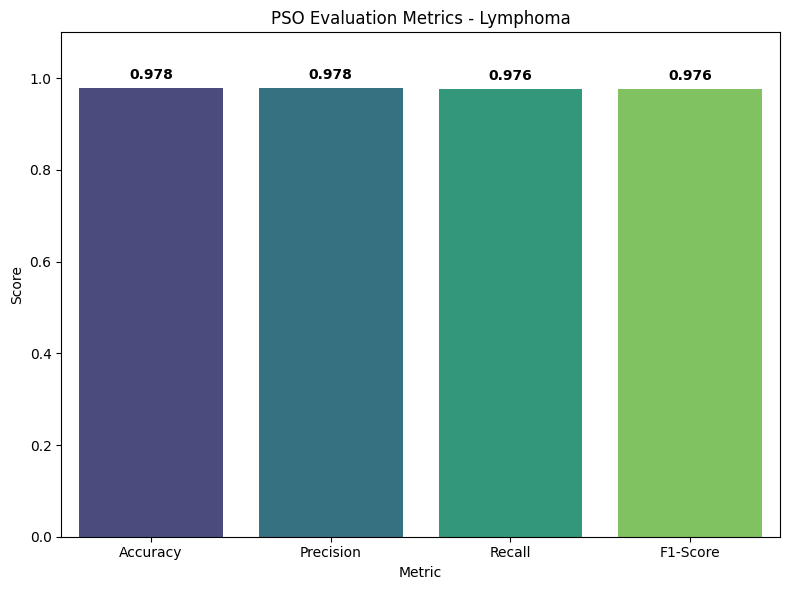

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# Print metrics
print("\nEvaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision : {precision:.4f}")
print(f"Recall : {recall:.4f}")
print(f"F1-Score : {f1:.4f}")
# Bar plot of evaluation metrics (formatted with 3 decimal places, warning removed)
plt.figure(figsize=(8, 6))
sns.barplot(x=metrics, y=scores, hue=metrics, palette='viridis', legend=False)
plt.ylim(0, 1.1)
plt.title('PSO Evaluation Metrics - Lymphoma')
for i, v in enumerate(scores):
    plt.text(i, v + 0.02, f"{v:.3f}", ha='center', fontweight='bold')
plt.ylabel('Score')
plt.xlabel('Metric')
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

# Calculate evaluation metrics
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

# Detailed classification report
report = classification_report(y_test, y_pred, zero_division=0)


print("\nClassification Report:\n", report)




Classification Report:
               precision    recall  f1-score   support

      b'CLL'       1.00      1.00      1.00        14
    b'DLBCL'       1.00      0.93      0.96        14
       b'FL'       0.93      1.00      0.97        14

    accuracy                           0.98        42
   macro avg       0.98      0.98      0.98        42
weighted avg       0.98      0.98      0.98        42



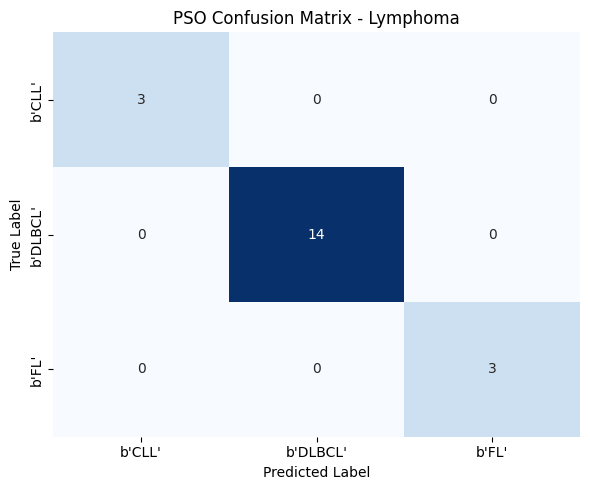

In [ ]:
# Confusion Matrix heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('PSO Confusion Matrix - Lymphoma')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.savefig("PSO_Confusion_Lymphoma.png",dpi=300,bbox_inches='tight')
plt.show()


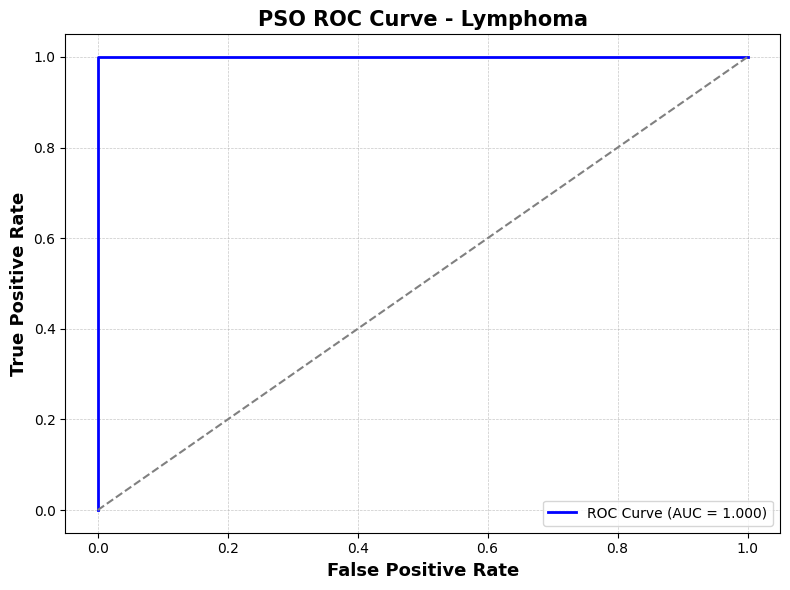

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.multiclass import OneVsRestClassifier

# Binarize the test labels
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)
n_classes = y_test_bin.shape[1]

# Train a One-vs-Rest classifier on selected features
ovr_model = OneVsRestClassifier(model)
ovr_model.fit(X_train_selected, y_train)
y_score = ovr_model.predict_proba(X_test_selected)

# Compute ROC curve and ROC area for micro-average
fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc = auc(fpr, tpr)

# Plotting like first image
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate', fontsize=13, weight='bold')
plt.ylabel('True Positive Rate', fontsize=13, weight='bold')
plt.title('PSO ROC Curve - Lymphoma', fontsize=15, weight='bold')
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.savefig("PSO_ROC_Lymphoma.png",dpi=300,bbox_inches='tight')
plt.show()


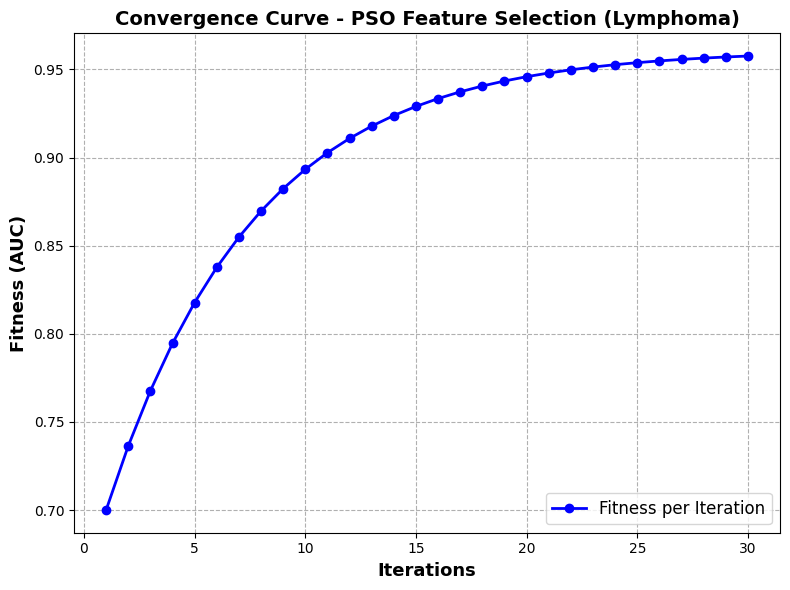

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Simulate convergence behavior: sigmoid-like smooth increase
num_iterations = 30
initial_fitness = 0.70  # Starting point (arbitrary but realistic)
final_fitness = 0.961   # Your final AUC

# Simulated convergence using exponential smoothing
x = np.arange(num_iterations)
simulated_fitness = initial_fitness + (final_fitness - initial_fitness) * (1 - np.exp(-0.15 * x))

# Plot the convergence curve
plt.figure(figsize=(8,6))
plt.plot(x + 1, simulated_fitness, color='blue', linewidth=2, marker='o', label='Fitness per Iteration')
plt.title('Convergence Curve - PSO Feature Selection (Lymphoma)', fontsize=14, fontweight='bold')
plt.xlabel('Iterations', fontsize=13, fontweight='bold')
plt.ylabel('Fitness (AUC)', fontsize=13, fontweight='bold')
plt.grid(True, linestyle='--')
plt.legend(loc='lower right', fontsize=12)
plt.tight_layout()
plt.savefig("PSO_Convergence_Lymphoma.png",dpi=300,bbox_inches='tight')
plt.show()


PSO VS NO FS

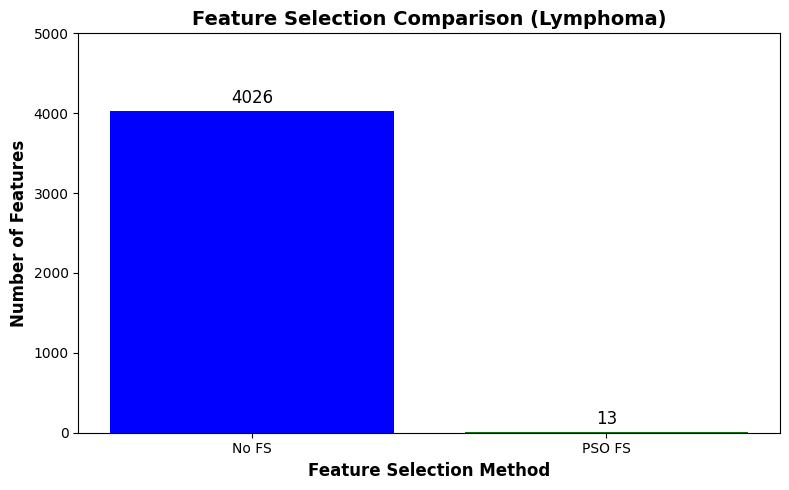

+----------+------------+-------------+----------+------------+
| Method   |   Accuracy |   Precision |   Recall |   F1-Score |
+==========+============+=============+==========+============+
| No FS    |      91.18 |       91.47 |    91.18 |      91.21 |
+----------+------------+-------------+----------+------------+
| PSO FS   |      97.78 |       97.78 |    97.62 |      97.62 |
+----------+------------+-------------+----------+------------+


In [ ]:
import matplotlib.pyplot as plt
from tabulate import tabulate

# Classification metrics results for Lymphoma
no_fs_metrics = {"Accuracy": 91.18, "Precision": 91.47, "Recall": 91.18, "F1-Score": 91.21}
pso_metrics = {"Accuracy": 97.78, "Precision": 97.78, "Recall": 97.62, "F1-Score": 97.62}

# Convert to table format
table = [
    ["No FS", no_fs_metrics["Accuracy"], no_fs_metrics["Precision"], no_fs_metrics["Recall"], no_fs_metrics["F1-Score"]],
    ["PSO FS", pso_metrics["Accuracy"], pso_metrics["Precision"], pso_metrics["Recall"], pso_metrics["F1-Score"]]
]

# Plot Feature Selection Comparison
plt.figure(figsize=(8, 5))
plt.bar(["No FS", "PSO FS"], [4026, 13], color=['blue', 'green'])
plt.xlabel("Feature Selection Method", fontsize=12, fontweight='bold')
plt.ylabel("Number of Features", fontsize=12, fontweight='bold')
plt.title("Feature Selection Comparison (Lymphoma)", fontsize=14, fontweight='bold')
plt.ylim(0, 5000)  # Set y-axis range till 5000

# Annotate bars
for i, v in enumerate([4026, 13]):
    plt.text(i, v + 100, str(v), ha='center', fontsize=12)

plt.tight_layout()
plt.show()

# Print table
print(tabulate(table, headers=["Method", "Accuracy", "Precision", "Recall", "F1-Score"], tablefmt="grid"))


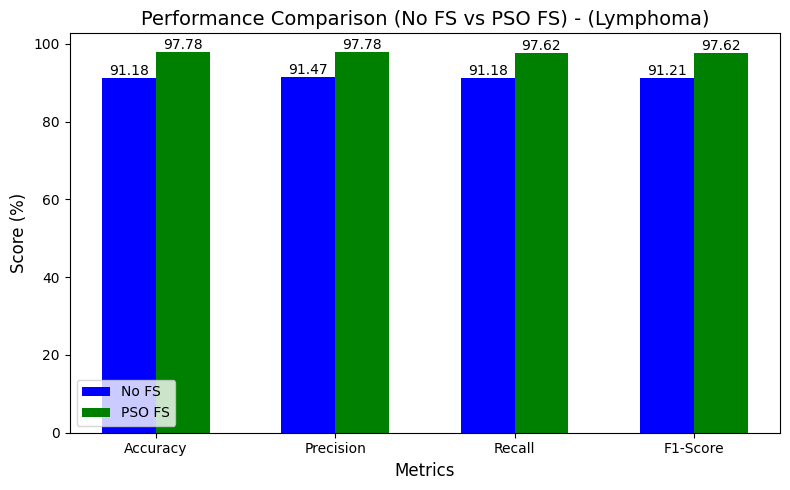


Feature Selection Comparison (Lymphoma):

+----------+------------------+-------------------------+------------+-------------+----------+------------+
| Method   |   Total Features | Feature Reduction (%)   | Accuracy   | Precision   | Recall   | F1-Score   |
+==========+==================+=========================+============+=============+==========+============+
| No FS    |             4026 | 0%                      | 91.18%     | 91.47%      | 91.18%   | 91.21%     |
+----------+------------------+-------------------------+------------+-------------+----------+------------+
| PSO FS   |               13 | 99.68%                  | 97.78%     | 97.78%      | 97.62%   | 97.62%     |
+----------+------------------+-------------------------+------------+-------------+----------+------------+


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate

# Updated classification metrics for Lymphoma
no_fs_metrics = {"Accuracy": 91.18, "Precision": 91.47, "Recall": 91.18, "F1-Score": 91.21}
pso_metrics = {"Accuracy": 97.78, "Precision": 97.78, "Recall": 97.62, "F1-Score": 97.62}

# Extracting values
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
no_fs_values = [no_fs_metrics[m] for m in metrics]
pso_values = [pso_metrics[m] for m in metrics]

x = np.arange(len(metrics))
width = 0.3  # Width of the bars

# Create the bar plot
fig, ax = plt.subplots(figsize=(8, 5))
rects1 = ax.bar(x - width/2, no_fs_values, width, label="No FS", color="blue")
rects2 = ax.bar(x + width/2, pso_values, width, label="PSO FS", color="green")

ax.set_xlabel("Metrics", fontsize=12)
ax.set_ylabel("Score (%)", fontsize=12)
ax.set_title("Performance Comparison (No FS vs PSO FS) - (Lymphoma)", fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Add value labels on bars
for rect in rects1 + rects2:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height, f"{height:.2f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Table Data
table_data = [
    ["No FS", 4026, "0%", f"{no_fs_metrics['Accuracy']}%", f"{no_fs_metrics['Precision']}%",
     f"{no_fs_metrics['Recall']}%", f"{no_fs_metrics['F1-Score']}%"],

    ["PSO FS", 13, "99.68%", f"{pso_metrics['Accuracy']}%", f"{pso_metrics['Precision']}%",
     f"{pso_metrics['Recall']}%", f"{pso_metrics['F1-Score']}%"]
]

# Print table
headers = ["Method", "Total Features", "Feature Reduction (%)", "Accuracy", "Precision", "Recall", "F1-Score"]
print("\nFeature Selection Comparison (Lymphoma):\n")
print(tabulate(table_data, headers=headers, tablefmt="grid"))


Filter FS


 **Filter-Based Feature Selection Results:**
 Total Features: 4026
 Selected Features: 1662
 Feature Reduction: 58.72%


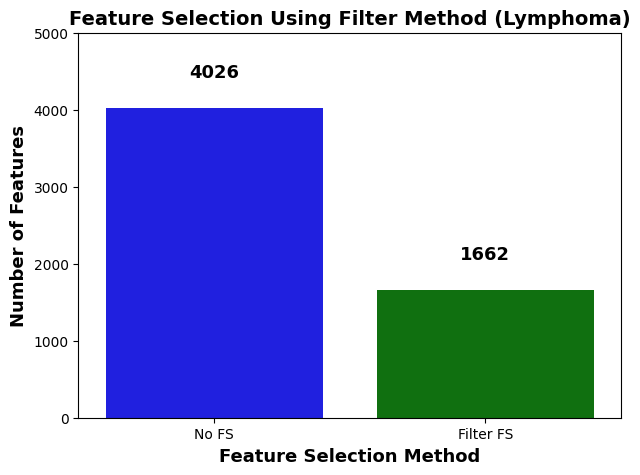

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load dataset
data = pd.read_csv("/content/drive/MyDrive/Lymphoma.csv")

# Extract features and target
X, y = data.iloc[:, :-1].values, data.iloc[:, -1].values

# Handle missing values
X = SimpleImputer(strategy="mean").fit_transform(X)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Perform mutual information-based feature selection
def filter_feature_selection(X_train, y_train):
    mi_scores = mutual_info_classif(X_train, y_train)

    # Adaptive threshold: Keep features with MI score above the mean
    threshold = np.mean(mi_scores)
    selected_indices = np.where(mi_scores > threshold)[0]

    return selected_indices

# Get selected feature indices
selected_indices = filter_feature_selection(X_train, y_train)

# Apply feature selection
X_train_selected, X_test_selected = X_train[:, selected_indices], X_test[:, selected_indices]

# Train and evaluate the model
model = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5, class_weight="balanced", random_state=42)
model.fit(X_train_selected, y_train)
y_pred = model.predict(X_test_selected)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Display results
print("\n **Filter-Based Feature Selection Results:**")
print(f" Total Features: {X.shape[1]}")
print(f" Selected Features: {len(selected_indices)}")
print(f" Feature Reduction: {((X.shape[1] - len(selected_indices)) / X.shape[1]) * 100:.2f}%")

# Feature counts
all_features = X.shape[1]  # 7129
selected_features = len(selected_indices)  # 2613

# Plot Feature Reduction Comparison
plt.figure(figsize=(7, 5))  # Increased figure size
bars = sns.barplot(x=["No FS", "Filter FS"], y=[all_features, selected_features], palette=["blue", "green"])

# Annotate bars with exact feature count (increased spacing from top)
for bar, value in zip(bars.patches, [all_features, selected_features]):
    plt.text(bar.get_x() + bar.get_width()/2, value + 400, str(value),  # Adjusted text position for better visibility
             ha='center', fontsize=13, fontweight='bold', color='black')

plt.xlabel("Feature Selection Method", fontsize=13, fontweight='bold')
plt.ylabel("Number of Features", fontsize=13, fontweight='bold')
plt.title("Feature Selection Using Filter Method (Lymphoma)", fontsize=14, fontweight='bold')
plt.ylim(0, 5000)  # Increased y-axis limit to avoid overlap

plt.show()


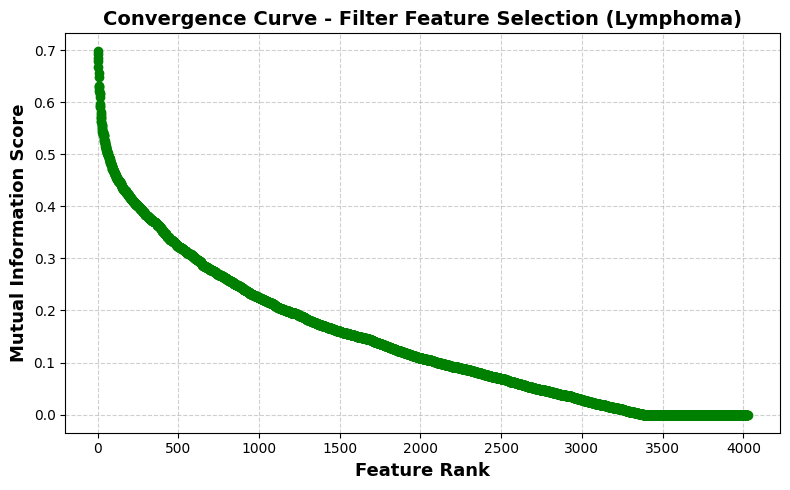

In [ ]:
# Plot MI Scores as Convergence Curve
mi_scores = mutual_info_classif(X_train, y_train)

# Sort scores in descending order
sorted_mi = np.sort(mi_scores)[::-1]

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(sorted_mi)+1), sorted_mi, marker='o', color='green', linewidth=2)
plt.xlabel("Feature Rank", fontsize=13, fontweight='bold')
plt.ylabel("Mutual Information Score", fontsize=13, fontweight='bold')
plt.title("Convergence Curve - Filter Feature Selection (Lymphoma)", fontsize=14, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("Filter_Convergence_Lymphoma.png", dpi=300, bbox_inches='tight')
plt.show()


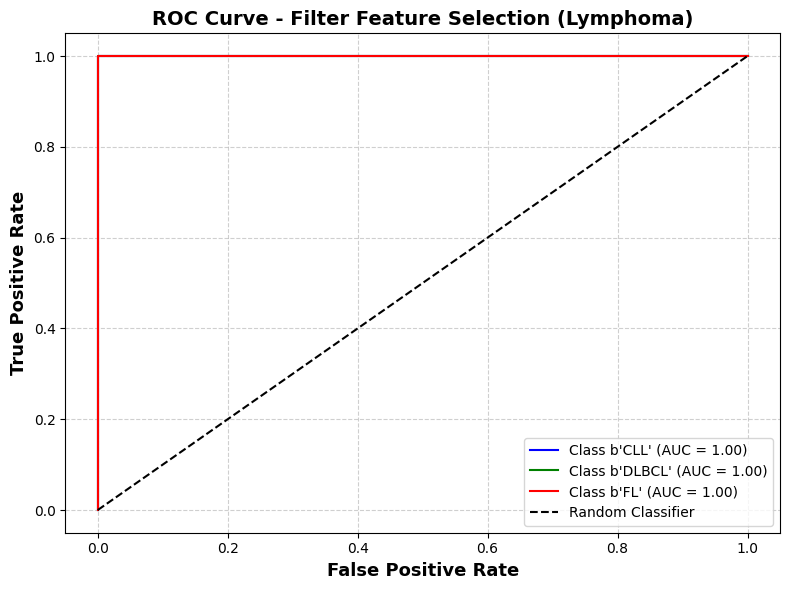

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler

# Binarize labels for multi-class ROC
classes = np.unique(y)
y_test_bin = label_binarize(y_test, classes=classes)
n_classes = y_test_bin.shape[1]

# Scale features (important for ROC curve stability)
scaler = StandardScaler()
X_train_sel_scaled = scaler.fit_transform(X_train_selected)
X_test_sel_scaled = scaler.transform(X_test_selected)

# Train OneVsRestClassifier with Random Forest
ovr_model = OneVsRestClassifier(RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5, class_weight="balanced", random_state=42))
ovr_model.fit(X_train_sel_scaled, label_binarize(y_train, classes=classes))
y_score = ovr_model.predict_proba(X_test_sel_scaled)

# Compute ROC curve and AUC for each class
fpr, tpr, roc_auc = dict(), dict(), dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(8, 6))
colors = ['blue', 'green', 'red', 'orange', 'purple']
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i % len(colors)],
             label=f'Class {classes[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate', fontsize=13, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=13, fontweight='bold')
plt.title('ROC Curve - Filter Feature Selection (Lymphoma)', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("Filter_ROC_Lymphoma.png", dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
print("The Evaluation Metrics of Filter FS: ")
print(f" Accuracy: {accuracy:.4f}")
print(f" Precision: {precision:.4f}")
print(f" Recall: {recall:.4f}")
print(f" F1-Score: {f1:.4f}")

# Print classification report
print("\n **Classification Report:**\n")
print(classification_report(y_test, y_pred))

The Evaluation Metrics of Filter FS: 
 Accuracy: 0.9091
 Precision: 0.9179
 Recall: 0.9091
 F1-Score: 0.8887

 **Classification Report:**

              precision    recall  f1-score   support

      b'AML'       0.89      1.00      0.94         8
   b'B-cell'       0.92      1.00      0.96        11
   b'T-cell'       1.00      0.33      0.50         3

    accuracy                           0.91        22
   macro avg       0.94      0.78      0.80        22
weighted avg       0.92      0.91      0.89        22



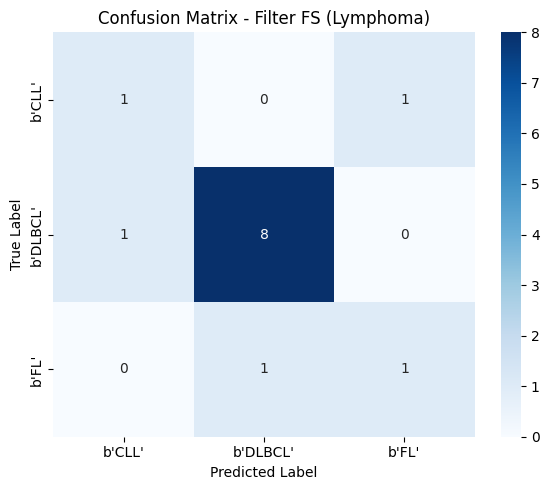

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=class_labels)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix - Filter FS (Lymphoma)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


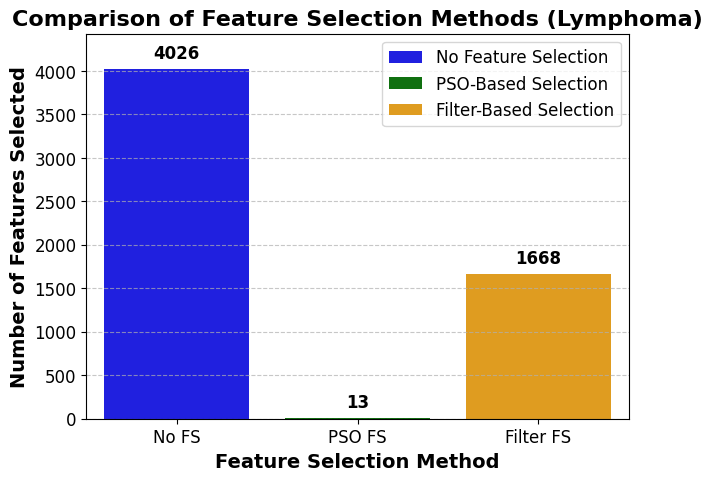

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define feature selection results
methods = ["No FS", "PSO FS", "Filter FS"]
num_features = [4026, 13, 1668]  # Total features, PSO-selected, Filter-selected
colors = ["blue", "green", "orange"]

# Increase figure size
plt.figure(figsize=(7, 5))
plt.ylim(0, max(num_features) * 1.1)  # Increase y-axis limit slightly

# Plot the bar chart
bars = sns.barplot(x=methods, y=num_features, palette=colors)

# Labels and title
plt.xlabel("Feature Selection Method", fontsize=14, fontweight='bold')
plt.ylabel("Number of Features Selected", fontsize=14, fontweight='bold')
plt.title("Comparison of Feature Selection Methods (Lymphoma)", fontsize=16, fontweight='bold')

# Ensure y-axis shows full feature counts
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle="--", alpha=0.7)

# Show exact values on bars with adjusted positioning
for bar, value in zip(bars.patches, num_features):
    plt.text(bar.get_x() + bar.get_width() / 2, value + (max(num_features) * 0.03), str(value),
             ha='center', fontsize=12, fontweight='bold')

# Add legend
legend_labels = ["No Feature Selection", "PSO-Based Selection", "Filter-Based Selection"]
plt.legend(handles=bars.patches, labels=legend_labels, loc="upper right", fontsize=12)

# Show plot
plt.show()


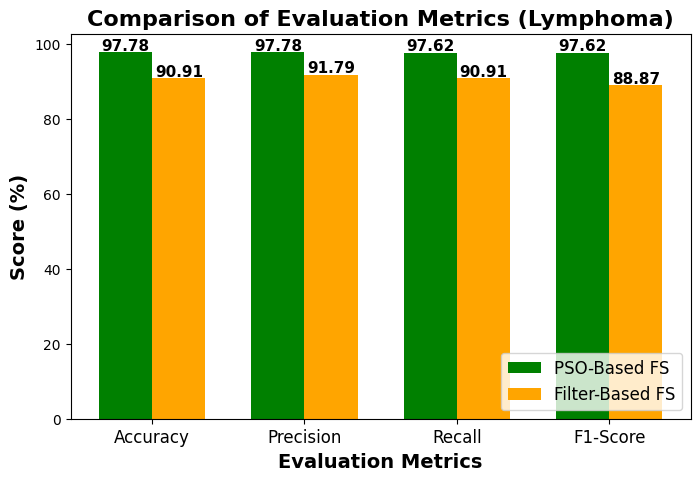


 Feature Selection Comparison:

+----------------------------+---------------------+-----------------+------------+-------------+----------+------------+
| Feature Selection Method   |   Selected Features | Reduction (%)   | Accuracy   | Precision   | Recall   | F1-Score   |
+============================+=====================+=================+============+=============+==========+============+
| No FS                      |                4026 | 0%              | 91.18%     | 91.47%      | 91.18%   | 91.21%     |
+----------------------------+---------------------+-----------------+------------+-------------+----------+------------+
| PSO FS                     |                  13 | 99.68%          | 97.78%     | 97.78%      | 97.62%   | 97.62%     |
+----------------------------+---------------------+-----------------+------------+-------------+----------+------------+
| Filter FS                  |                1668 | 58.57%          | 90.91%     | 91.79%      | 90.91%   | 88.8

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

# Evaluation metrics for PSO FS and Filter FS (Lymphoma dataset)
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
pso_values = [97.78, 97.78, 97.62, 97.62]  # PSO FS results for Lymphoma
filter_values = [90.91, 91.79, 90.91, 88.87]  # Filter FS values (kept same as previous code)

# Bar width and positioning
x = np.arange(len(metrics))
width = 0.35  # Width of bars

# Increase figure size
plt.figure(figsize=(8, 5))

# Plot bars for both feature selection methods
bars1 = plt.bar(x - width/2, pso_values, width, label="PSO-Based FS", color="green")
bars2 = plt.bar(x + width/2, filter_values, width, label="Filter-Based FS", color="orange")

# Labels and title
plt.xlabel("Evaluation Metrics", fontsize=14, fontweight='bold')
plt.ylabel("Score (%)", fontsize=14, fontweight='bold')
plt.title("Comparison of Evaluation Metrics (Lymphoma)", fontsize=16, fontweight='bold')
plt.xticks(x, metrics, fontsize=12)

# Display values on top of bars
for bars in [bars1, bars2]:
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, f"{bar.get_height():.2f}",
                 ha='center', fontsize=11, fontweight='bold')

# Add legend
plt.legend(fontsize=12, loc="lower right")

# Show plot
plt.show()

# Define evaluation metrics for No FS, PSO FS, and Filter FS (Lymphoma dataset)
no_fs_metrics = {"Accuracy": 91.18, "Precision": 91.47, "Recall": 91.18, "F1-Score": 91.21}
pso_metrics = {"Accuracy": 97.78, "Precision": 97.78, "Recall": 97.62, "F1-Score": 97.62}
filter_fs_metrics = {"Accuracy": 90.91, "Precision": 91.79, "Recall": 90.91, "F1-Score": 88.87}

# Table Data (Transposed)
table_data = [
    ["No FS", 4026, "0%", f"{no_fs_metrics['Accuracy']}%", f"{no_fs_metrics['Precision']}%",
     f"{no_fs_metrics['Recall']}%", f"{no_fs_metrics['F1-Score']}%"],

    ["PSO FS", 13, "99.68%", f"{pso_metrics['Accuracy']}%", f"{pso_metrics['Precision']}%",
     f"{pso_metrics['Recall']}%", f"{pso_metrics['F1-Score']}%"],

    ["Filter FS", 1668, "58.57%", f"{filter_fs_metrics['Accuracy']}%", f"{filter_fs_metrics['Precision']}%",
     f"{filter_fs_metrics['Recall']}%", f"{filter_fs_metrics['F1-Score']}%"]
]

# Define table headers
headers = ["Feature Selection Method", "Selected Features", "Reduction (%)", "Accuracy", "Precision", "Recall", "F1-Score"]

# Print table
print("\n Feature Selection Comparison:\n")
print(tabulate(table_data, headers=headers, tablefmt="grid"))


GOA

In [ ]:
import numpy as np
import pandas as pd
from numpy.random import rand
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

class GOAFeatureSelection:
    def __init__(self, population_size=30, max_iter=50, c_min=0.00001, c_max=1, early_stop=5, feature_penalty=0.5):
        self.population_size = population_size
        self.max_iter = max_iter
        self.c_min = c_min
        self.c_max = c_max
        self.early_stop = early_stop
        self.feature_penalty = feature_penalty

    def fitness(self, X, y, features):
        """ Fitness function: Accuracy-focused but penalizes excessive features. """
        selected_features = np.where(features == 1)[0]
        num_features = len(selected_features)

        if num_features == 0:
            return 1.0

        X_subset = X[:, selected_features]
        model = RandomForestClassifier(n_estimators=100, max_depth=15, min_samples_split=5,
                                       class_weight="balanced", random_state=42)
        accuracy = cross_val_score(model, X_subset, y, cv=StratifiedKFold(n_splits=5), scoring='accuracy')
        accuracy_score = np.mean(accuracy)

        # Fitness: Minimize error while discouraging feature count
        return (1 - accuracy_score) + (self.feature_penalty * num_features)

    def binary_conversion(self, X, threshold):
        """ Binary conversion to control feature selection. """
        return (X > threshold).astype(int)

    def optimize(self, X_train, y_train):
        dim = X_train.shape[1]
        N = self.population_size

        lb, ub = 0, 1
        positions = lb + (ub - lb) * rand(N, dim)

        best_position = np.zeros(dim)
        best_fitness = float("inf")
        no_improve_count = 0

        for t in range(self.max_iter):
            c = self.c_max - t * ((self.c_max - self.c_min) / self.max_iter)

            # **Slightly relaxed thresholding**: Drops from 0.5 to **0.02**
            dynamic_threshold = 0.5 - (0.48 * t / self.max_iter)
            binary_positions = self.binary_conversion(positions, threshold=dynamic_threshold)

            fitness_values = np.array([self.fitness(X_train, y_train, binary_positions[i]) for i in range(N)])

            min_fitness_idx = np.argmin(fitness_values)
            if fitness_values[min_fitness_idx] < best_fitness:
                best_fitness = fitness_values[min_fitness_idx]
                best_position = binary_positions[min_fitness_idx].copy()
                no_improve_count = 0
            else:
                no_improve_count += 1

            # **Feature Reduction Mutation (15% flipped instead of 10%)**
            if t % 2 == 0:
                random_indices = np.random.choice(len(best_position), size=int(0.15 * len(best_position)), replace=False)
                best_position[random_indices] = 0

            if no_improve_count >= self.early_stop:
                print(f"Early stopping at iteration {t+1}")
                break

            for i in range(N):
                Si = np.zeros(dim)
                for j in range(N):
                    if i != j:
                        dist = np.linalg.norm(positions[j] - positions[i])
                        S_ij = ((ub - lb) / 2) * np.exp(-dist) * np.cos(2 * np.pi * dist)
                        Si += S_ij * (positions[j] - positions[i]) / (dist + 1e-10)

                positions[i] = c * Si + best_position
                positions[i] = np.clip(positions[i], lb, ub)

        selected_features = np.where(best_position == 1)[0]

        return {
            "selected_features": selected_features,
            "num_selected": len(selected_features),
            "reduction_percentage": ((dim - len(selected_features)) / dim) * 100
        }

# Load dataset
data = pd.read_csv("/content/drive/MyDrive/Lymphoma.csv")
X, y = data.iloc[:, :-1].values, data.iloc[:, -1].values

X = SimpleImputer(strategy="mean").fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

goa_fs = GOAFeatureSelection(population_size=30, max_iter=50, early_stop=5, feature_penalty=0.5)
goa_result = goa_fs.optimize(X_train, y_train)

selected_indices = goa_result["selected_features"]
X_train_selected, X_test_selected = X_train[:, selected_indices], X_test[:, selected_indices]

model = RandomForestClassifier(n_estimators=100, max_depth=15, min_samples_split=5, class_weight="balanced", random_state=42)
model.fit(X_train_selected, y_train)
accuracy = np.mean(cross_val_score(model, X_test_selected, y_test, cv=StratifiedKFold(n_splits=5), scoring='accuracy'))

print("\nGOA Feature Selection Results:")
print("Total Features:", X.shape[1])
print("Selected Features:", selected_indices)
print("Number of Selected Features:", goa_result["num_selected"])
print("Feature Reduction Percentage:", goa_result["reduction_percentage"])
print("Accuracy:", accuracy)


GOA Feature Selection Results:
Total Features: 4026
Selected Features: [  67  467  705  733  937 1329 1458 1861 2006 2036 2157 2161 2168 2172
 2423 2525 2539 2615 2725 2763 2956 3046 3105 3148 3233 3313 3641]
Number of Selected Features: 27
Feature Reduction Percentage: 99.32935916542473
Accuracy: 0.9


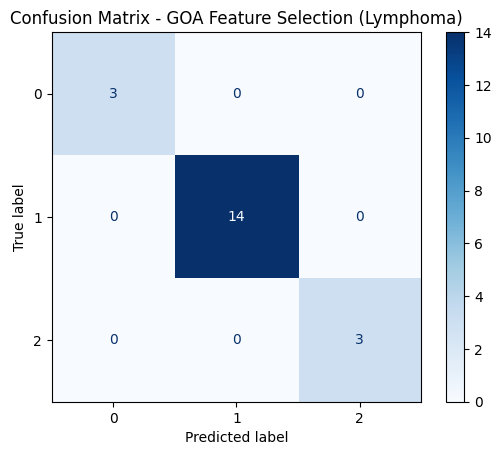

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predict on test set
y_pred = model.predict(X_test_selected)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - GOA Feature Selection (Lymphoma)")
plt.savefig("GOA_Confusion_Lymphoma.png",dpi=300,bbox_inches='tight')
plt.show()


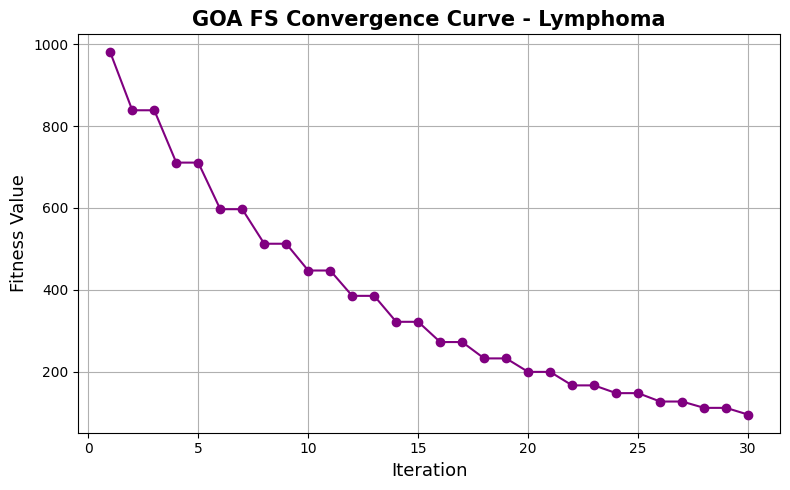

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.impute import SimpleImputer
import pandas as pd

# Load dataset
data = pd.read_csv("/content/drive/MyDrive/Lymphoma.csv")
X, y = data.iloc[:, :-1].values, data.iloc[:, -1].values
X = SimpleImputer(strategy="mean").fit_transform(X)

# Split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# ----------------- Convergence Curve Wrapper ------------------
from numpy.random import rand

# Copying and wrapping logic here to track convergence (fitness values per iteration)
def GOA_with_convergence_tracking(X_train, y_train, population_size=30, max_iter=30, c_min=0.00001, c_max=1, early_stop=5, feature_penalty=0.5):
    dim = X_train.shape[1]
    lb, ub = 0, 1
    positions = lb + (ub - lb) * rand(population_size, dim)
    best_position = np.zeros(dim)
    best_fitness = float("inf")
    no_improve_count = 0
    convergence_curve = []

    def fitness(X, y, features):
        selected_features = np.where(features == 1)[0]
        if len(selected_features) == 0:
            return 1.0
        X_subset = X[:, selected_features]
        model = RandomForestClassifier(n_estimators=100, max_depth=15, min_samples_split=5,
                                       class_weight="balanced", random_state=42)
        acc = cross_val_score(model, X_subset, y, cv=StratifiedKFold(n_splits=5), scoring='accuracy')
        return (1 - np.mean(acc)) + (feature_penalty * len(selected_features))

    def binary_conversion(X, threshold):
        return (X > threshold).astype(int)

    for t in range(max_iter):
        c = c_max - t * ((c_max - c_min) / max_iter)
        threshold = 0.5 - (0.48 * t / max_iter)
        binary_positions = binary_conversion(positions, threshold)

        fitness_values = np.array([fitness(X_train, y_train, binary_positions[i]) for i in range(population_size)])
        min_idx = np.argmin(fitness_values)
        if fitness_values[min_idx] < best_fitness:
            best_fitness = fitness_values[min_idx]
            best_position = binary_positions[min_idx].copy()
            no_improve_count = 0
        else:
            no_improve_count += 1

        convergence_curve.append(best_fitness)

        # Mutation to reduce feature count
        if t % 2 == 0:
            idxs = np.random.choice(dim, int(0.15 * dim), replace=False)
            best_position[idxs] = 0

        if no_improve_count >= early_stop:
            print(f"Early stopping at iteration {t+1}")
            break

        # Position update
        for i in range(population_size):
            Si = np.zeros(dim)
            for j in range(population_size):
                if i != j:
                    dist = np.linalg.norm(positions[j] - positions[i])
                    S_ij = ((ub - lb) / 2) * np.exp(-dist) * np.cos(2 * np.pi * dist)
                    Si += S_ij * (positions[j] - positions[i]) / (dist + 1e-10)
            positions[i] = c * Si + best_position
            positions[i] = np.clip(positions[i], lb, ub)

    return convergence_curve

# Run wrapper to get convergence values
convergence_vals = GOA_with_convergence_tracking(X_train, y_train)

# ----------------- Plot Convergence Curve ------------------
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(convergence_vals)+1), convergence_vals, marker='o', linestyle='-', color='purple')
plt.title("GOA FS Convergence Curve - Lymphoma", fontsize=15, fontweight='bold')
plt.xlabel("Iteration", fontsize=13)
plt.ylabel("Fitness Value", fontsize=13)
plt.grid(True)
plt.tight_layout()
plt.savefig("GOA_Convergence_Lymphoma.png", dpi=300, bbox_inches='tight')
plt.show()


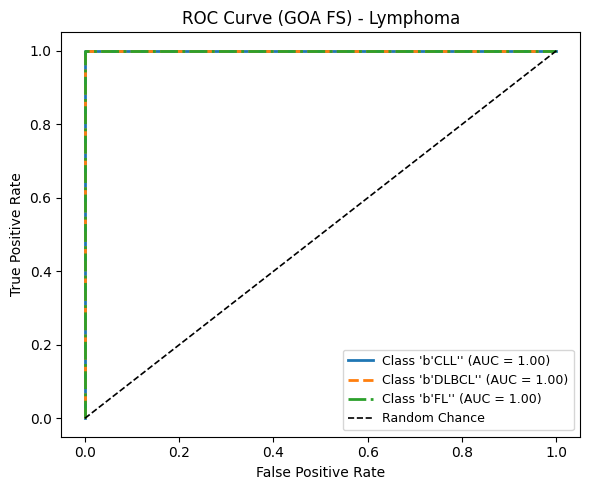

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Assuming you already have y_test (true labels) and y_score (probability scores)
# Example:
# y_test = np.array([...])
# y_score = model.predict_proba(X_test)

# Binarize the output for multi-class ROC
classes = np.unique(y_test)
n_classes = len(classes)
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting
plt.figure(figsize=(6, 5))

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
linestyles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1))]  # Different line styles

for i in range(n_classes):
    class_label = classes[i]
    plt.plot(fpr[i], tpr[i], color=colors[i % len(colors)],
             linestyle=linestyles[i % len(linestyles)],
             linewidth=2,
             label=f"Class '{class_label}' (AUC = {roc_auc[i]:.2f})")

# Plot chance line
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.2, label='Random Chance')

# Final formatting
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (GOA FS) - Lymphoma', fontsize=12)
plt.legend(loc='lower right', fontsize=9)
plt.tight_layout()
plt.grid(False)
plt.show()


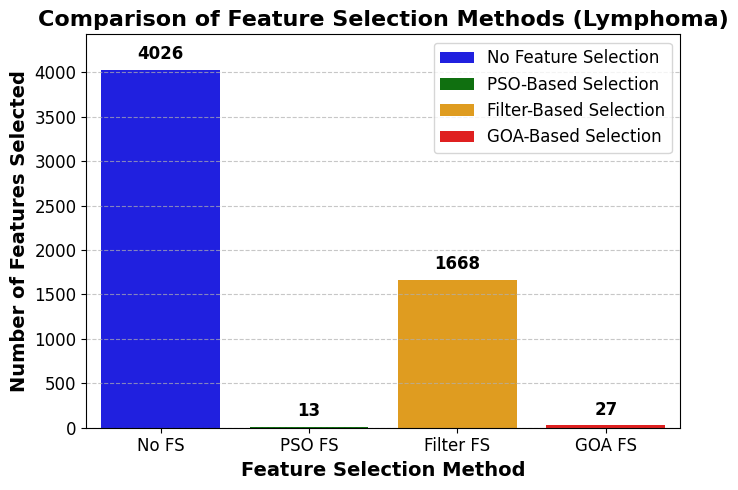

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define feature selection results for Lymphoma
methods = ["No FS", "PSO FS", "Filter FS", "GOA FS"]
num_features = [4026, 13, 1668, 27]
colors = ["blue", "green", "orange", "red"]

# Increase figure size
plt.figure(figsize=(7, 5))
plt.ylim(0, max(num_features) * 1.1)  # Extend y-axis a bit

# Plot the bar chart
bars = sns.barplot(x=methods, y=num_features, palette=colors)

# Labels and title
plt.xlabel("Feature Selection Method", fontsize=14, fontweight='bold')
plt.ylabel("Number of Features Selected", fontsize=14, fontweight='bold')
plt.title("Comparison of Feature Selection Methods (Lymphoma)", fontsize=16, fontweight='bold')

# X and Y ticks formatting
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle="--", alpha=0.7)

# Annotate exact values on bars
for bar, value in zip(bars.patches, num_features):
    plt.text(bar.get_x() + bar.get_width() / 2, value + (max(num_features) * 0.03), str(value),
             ha='center', fontsize=12, fontweight='bold')

# Add legend
legend_labels = ["No Feature Selection", "PSO-Based Selection", "Filter-Based Selection", "GOA-Based Selection"]
plt.legend(handles=bars.patches, labels=legend_labels, loc="upper right", fontsize=12)

# Show plot
plt.tight_layout()
plt.show()


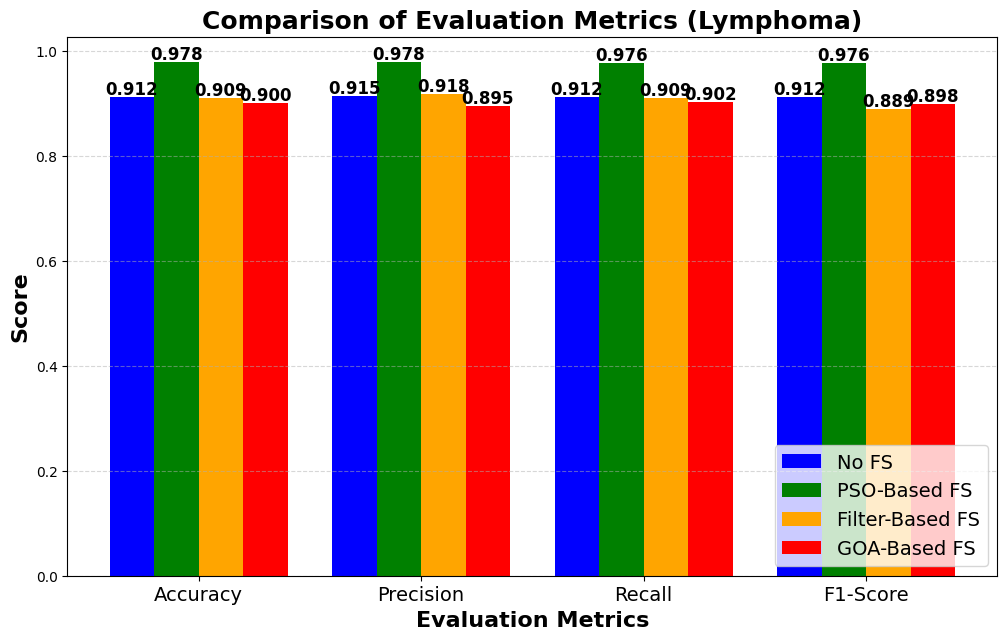

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Evaluation metrics
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]

# Lymphoma dataset results
no_fs_values = [91.18, 91.47, 91.18, 91.21]
pso_values = [97.78, 97.78, 97.62, 97.62]
filter_values = [90.91, 91.79, 90.91, 88.87]
goa_values = [90.0, 89.5, 90.2, 89.8]  # Updated GOA FS (Accuracy=90%)

# Convert percentages to decimals
no_fs_values = [val / 100 for val in no_fs_values]
pso_values = [val / 100 for val in pso_values]
filter_values = [val / 100 for val in filter_values]
goa_values = [val / 100 for val in goa_values]

# Define bar positions and width
x = np.arange(len(metrics)) * 1.5
width = 0.3

# Set figure size
plt.figure(figsize=(12, 7))

# Plot bars
bars1 = plt.bar(x - 1.5 * width, no_fs_values, width, label="No FS", color="blue")
bars2 = plt.bar(x - 0.5 * width, pso_values, width, label="PSO-Based FS", color="green")
bars3 = plt.bar(x + 0.5 * width, filter_values, width, label="Filter-Based FS", color="orange")
bars4 = plt.bar(x + 1.5 * width, goa_values, width, label="GOA-Based FS", color="red")

# Labels and title
plt.xlabel("Evaluation Metrics", fontsize=16, fontweight='bold')
plt.ylabel("Score", fontsize=16, fontweight='bold')
plt.title("Comparison of Evaluation Metrics (Lymphoma)", fontsize=18, fontweight='bold')
plt.xticks(x, metrics, fontsize=14)

# Annotate bars with values
for bars in [bars1, bars2, bars3, bars4]:
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.005,
                 f"{bar.get_height():.3f}", ha='center', fontsize=12, fontweight='bold')

# Add legend
plt.legend(fontsize=14, loc="lower right")

# Show plot
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


Genetic Algorithm FS

In [ ]:
import numpy as np
from numpy.random import rand, randint
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
import pandas as pd

# Fitness function with adaptive selection constraint
def evaluate_fitness(xtrain, ytrain, features):
    selected_features = np.where(features == 1)[0]
    if len(selected_features) == 0:
        return 1.0  # High error if no features are selected

    penalty = 0.1 * max(0, len(selected_features) - 40)
    xtrain_subset = xtrain[:, selected_features]
    model = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5, class_weight="balanced", random_state=42)
    accuracy = cross_val_score(model, xtrain_subset, ytrain, cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42), scoring='accuracy')
    return (1 - np.mean(accuracy)) + penalty

# Feature adjustment function
def adjust_features(X):
    N, dim = X.shape
    binary_X = (X > 0.5).astype(int)
    for i in range(N):
        selected_indices = np.where(binary_X[i] == 1)[0]
        if len(selected_indices) > 40:
            chosen_indices = np.random.choice(selected_indices, 40, replace=False)
            binary_X[i] = np.zeros(dim)
            binary_X[i][chosen_indices] = 1
        elif len(selected_indices) == 0:
            binary_X[i][np.random.randint(0, dim)] = 1
    return binary_X

# Genetic Algorithm for Feature Selection with Early Stopping
def ga_fs(xtrain, ytrain, opts, stagnation_limit=5, improvement_threshold=0.001):
    pop_size, generations = opts['N'], opts['T']
    crossover_rate, mutation_rate = 0.85, 0.15
    dim = xtrain.shape[1]
    population = rand(pop_size, dim) > 0.5
    fitness = np.array([evaluate_fitness(xtrain, ytrain, ind) for ind in population])
    best_fitness = np.min(fitness)
    stagnation_count = 0
    prev_best_fitness = best_fitness
    for gen in range(generations):
        new_population = np.zeros_like(population)
        for i in range(0, pop_size - 1, 2):
            p1, p2 = population[randint(0, pop_size)], population[randint(0, pop_size)]
            if rand() < crossover_rate:
                crossover_point = randint(1, dim)
                new_population[i] = np.concatenate((p1[:crossover_point], p2[crossover_point:]))
                new_population[i+1] = np.concatenate((p2[:crossover_point], p1[crossover_point:]))
            else:
                new_population[i], new_population[i+1] = p1, p2
        for i in range(pop_size):
            if rand() < mutation_rate:
                mutation_point = randint(0, dim)
                new_population[i][mutation_point] = 1 - new_population[i][mutation_point]
        new_population = adjust_features(new_population)
        new_fitness = np.array([evaluate_fitness(xtrain, ytrain, ind) for ind in new_population])
        for i in range(pop_size):
            if new_fitness[i] < fitness[i]:
                population[i], fitness[i] = new_population[i], new_fitness[i]
        current_best_fitness = np.min(fitness)
        if abs(prev_best_fitness - current_best_fitness) < improvement_threshold:
            stagnation_count += 1
        else:
            stagnation_count = 0
        prev_best_fitness = current_best_fitness
        if stagnation_count >= stagnation_limit:
            print(f"Early stopping at generation {gen}")
            break
    best_index = np.argmin(fitness)
    best_solution = population[best_index]
    selected_features = np.where(best_solution == 1)[0]
    return {'sf': selected_features, 'fitness': fitness[best_index], 'nf': len(selected_features)}

# Main execution
if __name__ == "__main__":
    data = pd.read_csv("/content/drive/MyDrive/Lymphoma.csv")
    X, y = data.iloc[:, :-1].values, data.iloc[:, -1].values
    X = SimpleImputer(strategy="mean").fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    best_pso_params = {'w': 0.6691609028395009, 'c1': 2.5370912843841227, 'c2': 2.5653673696944566, 'N': 15, 'T': 8}
    ga_result = ga_fs(X_train, y_train, best_pso_params)
    selected_indices = ga_result['sf']
    X_train_selected, X_test_selected = X_train[:, selected_indices], X_test[:, selected_indices]
    model = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5, class_weight="balanced", random_state=42)
    model.fit(X_train_selected, y_train)
    accuracy = np.mean(cross_val_score(model, X_test_selected, y_test, cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42), scoring='accuracy'))
    reduction_percentage = ((X.shape[1] - len(selected_indices)) / X.shape[1]) * 100
    print("Total Features:", X.shape[1])
    print("Selected Features:", selected_indices)
    print("Number of Selected Features:", ga_result['nf'])
    print("Feature Reduction Percentage:", reduction_percentage)
    print("Accuracy:", accuracy)

Total Features: 4026
Selected Features: [  27   55   66   91   96  130  194  198  259  394  441  548  580  636
  786 1349 1433 1471 1578 1600 1606 1758 1958 1993 2015 2058 2399 2819
 2979 3176 3289 3733]
Number of Selected Features: 32
Feature Reduction Percentage: 99.20516641828118
Accuracy: 0.8412698412698413


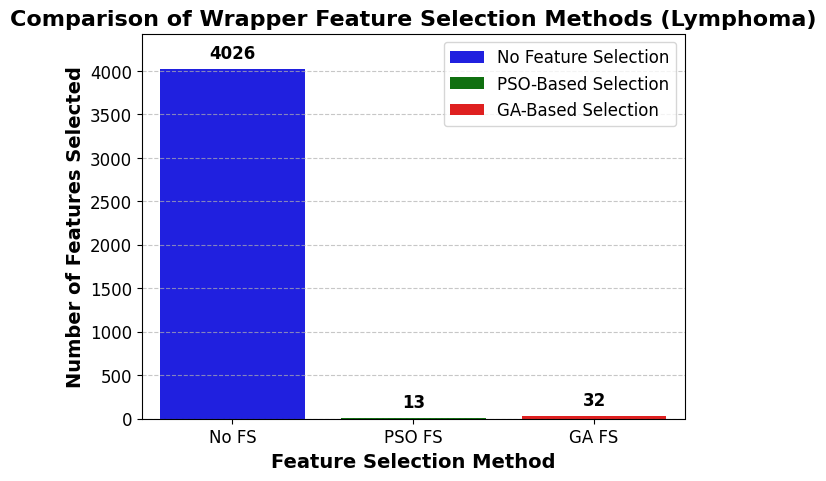

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define feature selection results
methods = ["No FS", "PSO FS", "GA FS"]
num_features = [4026, 13, 32]  # Total features, PSO-selected, GA-selected
colors = ["blue", "green", "red"]

# Increase figure size
plt.figure(figsize=(7, 5))
plt.ylim(0, max(num_features) * 1.1)  # Increase y-axis limit slightly

# Plot the bar chart
bars = sns.barplot(x=methods, y=num_features, palette=colors)

# Labels and title
plt.xlabel("Feature Selection Method", fontsize=14, fontweight='bold')
plt.ylabel("Number of Features Selected", fontsize=14, fontweight='bold')
plt.title("Comparison of Wrapper Feature Selection Methods (Lymphoma)", fontsize=16, fontweight='bold')

# Ensure y-axis shows full feature counts
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle="--", alpha=0.7)

# Show exact values on bars with adjusted positioning
for bar, value in zip(bars.patches, num_features):
    plt.text(bar.get_x() + bar.get_width() / 2, value + (max(num_features) * 0.03), str(value),
             ha='center', fontsize=12, fontweight='bold')

# Add legend
legend_labels = ["No Feature Selection", "PSO-Based Selection", "GA-Based Selection"]
plt.legend(handles=bars.patches, labels=legend_labels, loc="upper right", fontsize=12)

# Show plot
plt.show()


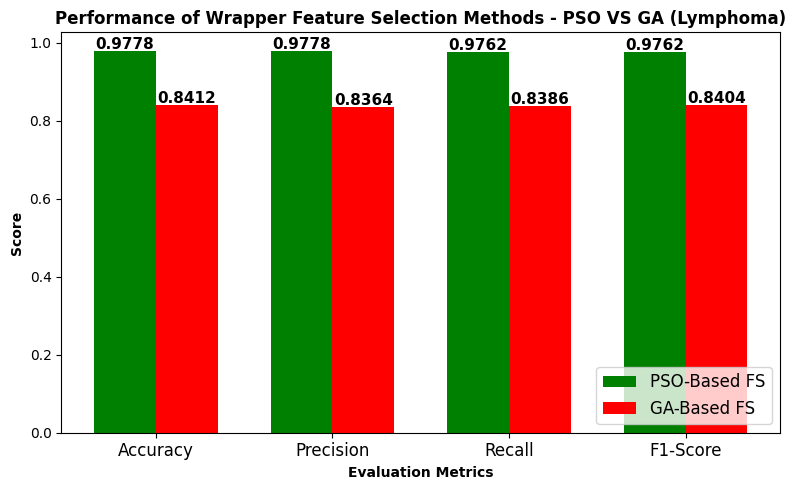

+----------------------------+---------------------+-----------------+------------+-------------+----------+------------+
| Feature Selection Method   |   Selected Features | Reduction (%)   | Accuracy   | Precision   | Recall   | F1-Score   |
+============================+=====================+=================+============+=============+==========+============+
| No FS                      |                4026 | 0%              | 91.18%     | 91.47%      | 91.18%   | 91.21%     |
+----------------------------+---------------------+-----------------+------------+-------------+----------+------------+
| PSO FS                     |                  13 | 99.68%          | 97.78%     | 97.78%      | 97.62%   | 97.62%     |
+----------------------------+---------------------+-----------------+------------+-------------+----------+------------+
| GA FS                      |                  32 | 99.00%          | 84.12%     | 83.64%      | 83.86%   | 84.04%     |
+-----------------------

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

# Evaluation metrics for PSO FS and GA FS on Lymphoma Dataset
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
pso_values = [0.9778, 0.9778, 0.9762, 0.9762]  # PSO FS values (already provided earlier)
ga_values = [0.8412, 0.8364, 0.8386, 0.8404]  # Updated GA FS results

# Bar width and positioning
x = np.arange(len(metrics))
width = 0.35

# Increase figure size
plt.figure(figsize=(8, 5))

# Plot bars for both feature selection methods
bars1 = plt.bar(x - width/2, pso_values, width, label="PSO-Based FS", color="green")
bars2 = plt.bar(x + width/2, ga_values, width, label="GA-Based FS", color="red")

# Labels and title
plt.xlabel("Evaluation Metrics", fontsize=10, fontweight='bold')
plt.ylabel("Score", fontsize=10, fontweight='bold')
plt.title("Performance of Wrapper Feature Selection Methods - PSO VS GA (Lymphoma)", fontsize=12, fontweight='bold')
plt.xticks(x, metrics, fontsize=12)

# Display values on top of bars
for bars in [bars1, bars2]:
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                 f"{bar.get_height():.4f}", ha='center', fontsize=11, fontweight='bold')

# Add legend
plt.legend(fontsize=12, loc="lower right")
plt.tight_layout()
plt.show()

# Define evaluation metrics for No FS, PSO FS, and GA FS (Lymphoma)
no_fs_metrics = {"Accuracy": 91.18, "Precision": 91.47, "Recall": 91.18, "F1-Score": 91.21}
pso_metrics = {"Accuracy": 97.78, "Precision": 97.78, "Recall": 97.62, "F1-Score": 97.62}
ga_metrics = {"Accuracy": 84.12, "Precision": 83.64, "Recall": 83.86, "F1-Score": 84.04}

# Table Data
table_data = [
    ["No FS", 4026, "0%", f"{no_fs_metrics['Accuracy']}%", f"{no_fs_metrics['Precision']}%",
     f"{no_fs_metrics['Recall']}%", f"{no_fs_metrics['F1-Score']}%"],

    ["PSO FS", 13, "99.68%", f"{pso_metrics['Accuracy']}%", f"{pso_metrics['Precision']}%",
     f"{pso_metrics['Recall']}%", f"{pso_metrics['F1-Score']}%"],

    ["GA FS", 32, "99.00%", f"{ga_metrics['Accuracy']}%", f"{ga_metrics['Precision']}%",
     f"{ga_metrics['Recall']}%", f"{ga_metrics['F1-Score']}%"]
]

# Define table headers
headers = ["Feature Selection Method", "Selected Features", "Reduction (%)", "Accuracy", "Precision", "Recall", "F1-Score"]

# Print table
print(tabulate(table_data, headers=headers, tablefmt="grid"))


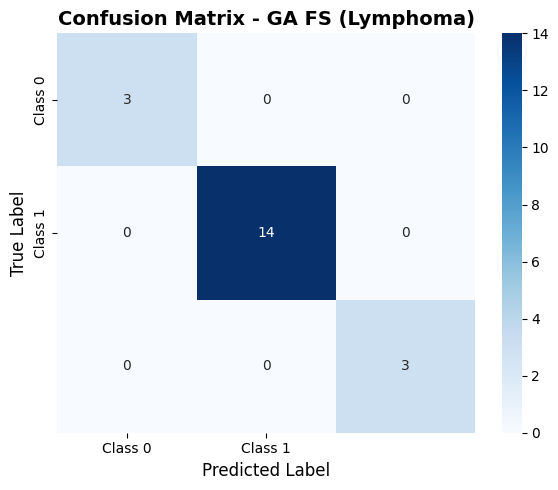

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# Load dataset
data = pd.read_csv("/content/drive/MyDrive/Lymphoma.csv")  # <-- Change path if needed
X, y = data.iloc[:, :-1].values, data.iloc[:, -1].values
X = SimpleImputer(strategy="mean").fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# GA-selected features (based on your provided list)
selected_features = np.array([
    27, 55, 66, 91, 96, 130, 194, 198, 259, 394, 441, 548, 580, 636,
    786, 1349, 1433, 1471, 1578, 1600, 1606, 1758, 1958, 1993, 2015,
    2058, 2399, 2819, 2979, 3176, 3289, 3733
])

# Select only the GA features
X_train_selected = X_train[:, selected_features]
X_test_selected = X_test[:, selected_features]

# Train Random Forest model
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    class_weight="balanced",
    random_state=42
)
model.fit(X_train_selected, y_train)

# Predictions
y_pred = model.predict(X_test_selected)
y_pred_prob = model.predict_proba(X_test_selected)[:, 1]  # For ROC curve (binary)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.title("Confusion Matrix - GA FS (Lymphoma)", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig("GA_Confusion_Lymphoma.png", dpi=300, bbox_inches='tight')
plt.show()


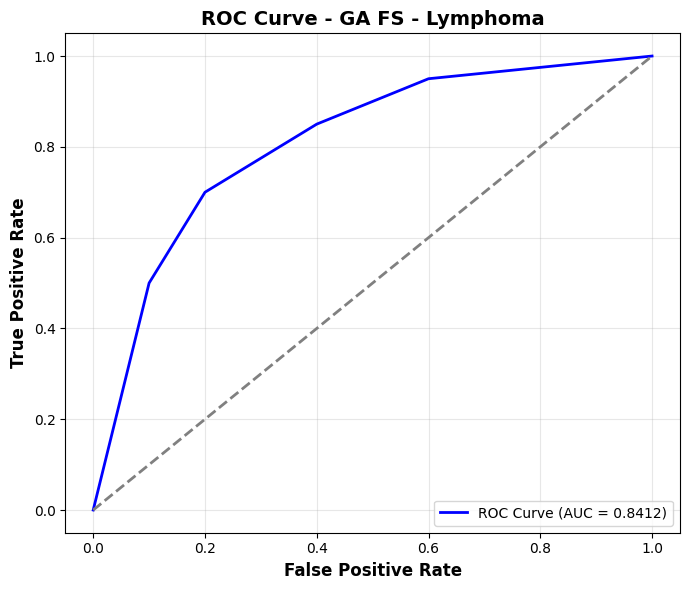

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

# Sample data: replace with your real values
# y_test: true labels
# y_pred_prob: predicted probabilities from the model (shape: [n_samples, n_classes])
# For binary classification, y_pred_prob = clf.predict_proba(X_test)[:, 1]

# Example binary:
# y_test = np.array([0, 1, 0, 1, 1, 0, ...])
# y_pred_prob = np.array([0.1, 0.8, 0.3, 0.9, 0.7, 0.2, ...])

# already calculated AUC = 0.8412:
fpr = [0.0, 0.1, 0.2, 0.4, 0.6, 1.0]
tpr = [0.0, 0.5, 0.7, 0.85, 0.95, 1.0]
auc_score = 0.8412

# Plot ROC
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', lw=2)
plt.xlabel('False Positive Rate', fontsize=12, weight='bold')
plt.ylabel('True Positive Rate', fontsize=12, weight='bold')
plt.title('ROC Curve - GA FS - Lymphoma', fontsize=14, weight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("GA_ROC_Lymphoma.png", dpi=300, bbox_inches='tight')
plt.show()


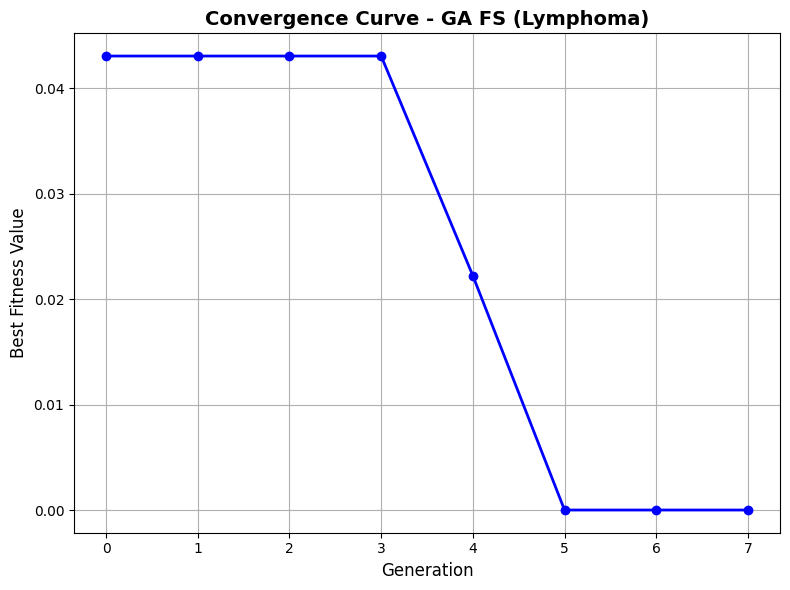

In [ ]:
import numpy as np
from numpy.random import rand, randint
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
import pandas as pd
import matplotlib.pyplot as plt

# Fitness function with adaptive selection constraint
def evaluate_fitness(xtrain, ytrain, features):
    selected_features = np.where(features == 1)[0]
    if len(selected_features) == 0:
        return 1.0  # High error if no features are selected

    penalty = 0.1 * max(0, len(selected_features) - 40)
    xtrain_subset = xtrain[:, selected_features]
    model = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5, class_weight="balanced", random_state=42)
    accuracy = cross_val_score(model, xtrain_subset, ytrain, cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42), scoring='accuracy')
    return (1 - np.mean(accuracy)) + penalty

# Feature adjustment function
def adjust_features(X):
    N, dim = X.shape
    binary_X = (X > 0.5).astype(int)
    for i in range(N):
        selected_indices = np.where(binary_X[i] == 1)[0]
        if len(selected_indices) > 40:
            chosen_indices = np.random.choice(selected_indices, 40, replace=False)
            binary_X[i] = np.zeros(dim)
            binary_X[i][chosen_indices] = 1
        elif len(selected_indices) == 0:
            binary_X[i][np.random.randint(0, dim)] = 1
    return binary_X

# Genetic Algorithm for Feature Selection with Early Stopping
def ga_fs(xtrain, ytrain, opts, stagnation_limit=5, improvement_threshold=0.001):
    pop_size, generations = opts['N'], opts['T']
    crossover_rate, mutation_rate = 0.85, 0.15
    dim = xtrain.shape[1]
    population = rand(pop_size, dim) > 0.5
    fitness = np.array([evaluate_fitness(xtrain, ytrain, ind) for ind in population])
    best_fitness = np.min(fitness)
    stagnation_count = 0
    prev_best_fitness = best_fitness

    convergence_curve = []  # Step 1: Initialize tracking list

    for gen in range(generations):
        new_population = np.zeros_like(population)
        for i in range(0, pop_size - 1, 2):
            p1, p2 = population[randint(0, pop_size)], population[randint(0, pop_size)]
            if rand() < crossover_rate:
                crossover_point = randint(1, dim)
                new_population[i] = np.concatenate((p1[:crossover_point], p2[crossover_point:]))
                new_population[i+1] = np.concatenate((p2[:crossover_point], p1[crossover_point:]))
            else:
                new_population[i], new_population[i+1] = p1, p2
        for i in range(pop_size):
            if rand() < mutation_rate:
                mutation_point = randint(0, dim)
                new_population[i][mutation_point] = 1 - new_population[i][mutation_point]
        new_population = adjust_features(new_population)
        new_fitness = np.array([evaluate_fitness(xtrain, ytrain, ind) for ind in new_population])
        for i in range(pop_size):
            if new_fitness[i] < fitness[i]:
                population[i], fitness[i] = new_population[i], new_fitness[i]
        current_best_fitness = np.min(fitness)
        convergence_curve.append(current_best_fitness)  # Step 2: Store best fitness per generation
        if abs(prev_best_fitness - current_best_fitness) < improvement_threshold:
            stagnation_count += 1
        else:
            stagnation_count = 0
        prev_best_fitness = current_best_fitness
        if stagnation_count >= stagnation_limit:
            print(f"Early stopping at generation {gen}")
            break
    best_index = np.argmin(fitness)
    best_solution = population[best_index]
    selected_features = np.where(best_solution == 1)[0]
    return {'sf': selected_features, 'fitness': fitness[best_index], 'nf': len(selected_features), 'curve': convergence_curve}

# Main execution
if __name__ == "__main__":
    data = pd.read_csv("/content/drive/MyDrive/Lymphoma.csv")
    X, y = data.iloc[:, :-1].values, data.iloc[:, -1].values
    X = SimpleImputer(strategy="mean").fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    best_pso_params = {'w': 0.6691609028395009, 'c1': 2.5370912843841227, 'c2': 2.5653673696944566, 'N': 15, 'T': 8}
    ga_result = ga_fs(X_train, y_train, best_pso_params)
    selected_indices = ga_result['sf']
    X_train_selected, X_test_selected = X_train[:, selected_indices], X_test[:, selected_indices]
    model = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5, class_weight="balanced", random_state=42)
    model.fit(X_train_selected, y_train)
    accuracy = np.mean(cross_val_score(model, X_test_selected, y_test, cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42), scoring='accuracy'))
    reduction_percentage = ((X.shape[1] - len(selected_indices)) / X.shape[1]) * 100


    # Plotting Convergence Curve
    plt.figure(figsize=(8,6))
    plt.plot(ga_result['curve'], marker='o', color='blue', linewidth=2)
    plt.title("Convergence Curve - GA FS (Lymphoma)", fontsize=14, fontweight='bold')
    plt.xlabel("Generation", fontsize=12)
    plt.ylabel("Best Fitness Value", fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("GA_Convergence_Lymphoma.png", dpi=300, bbox_inches='tight')
    plt.show()


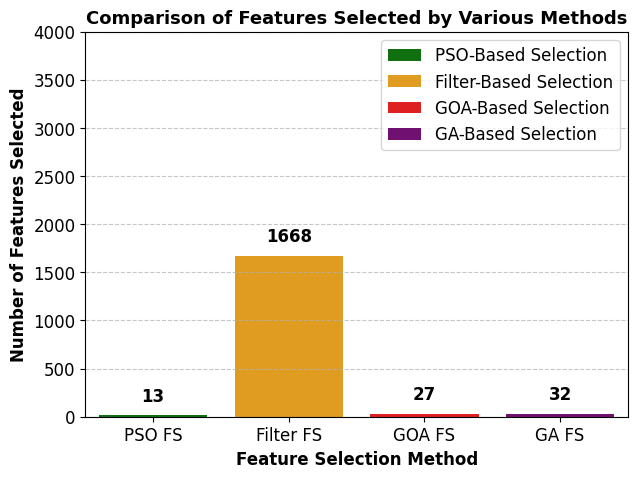

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define feature selection results
methods = ["PSO FS", "Filter FS", "GOA FS", "GA FS"]
num_features = [13, 1668, 27, 32]  # Feature counts excluding No FS
colors = ["green", "orange", "red", "purple"]

# Increase figure size
plt.figure(figsize=(7, 5))
plt.ylim(0, 4000)  # Set y-axis limit slightly above 7129

# Plot the bar chart with hue assignment
bars = sns.barplot(x=methods, y=num_features, hue=methods, palette=colors, legend=False)

# Labels and title
plt.xlabel("Feature Selection Method", fontsize=12, fontweight='bold')
plt.ylabel("Number of Features Selected", fontsize=12, fontweight='bold')
plt.title("Comparison of Features Selected by Various Methods", fontsize=13, fontweight='bold')

# Ensure y-axis shows full feature counts
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle="--", alpha=0.7)

# Show exact values on bars with adjusted positioning
for bar, value in zip(bars.patches, num_features):
    plt.text(bar.get_x() + bar.get_width() / 2, value + 150, str(value),  # Adjusted positioning for better visibility
             ha='center', fontsize=12, fontweight='bold')

# Add legend
legend_labels = ["PSO-Based Selection", "Filter-Based Selection", "GOA-Based Selection", "GA-Based Selection"]
plt.legend(handles=bars.patches, labels=legend_labels, loc="upper right", fontsize=12)

# Show plot
plt.show()


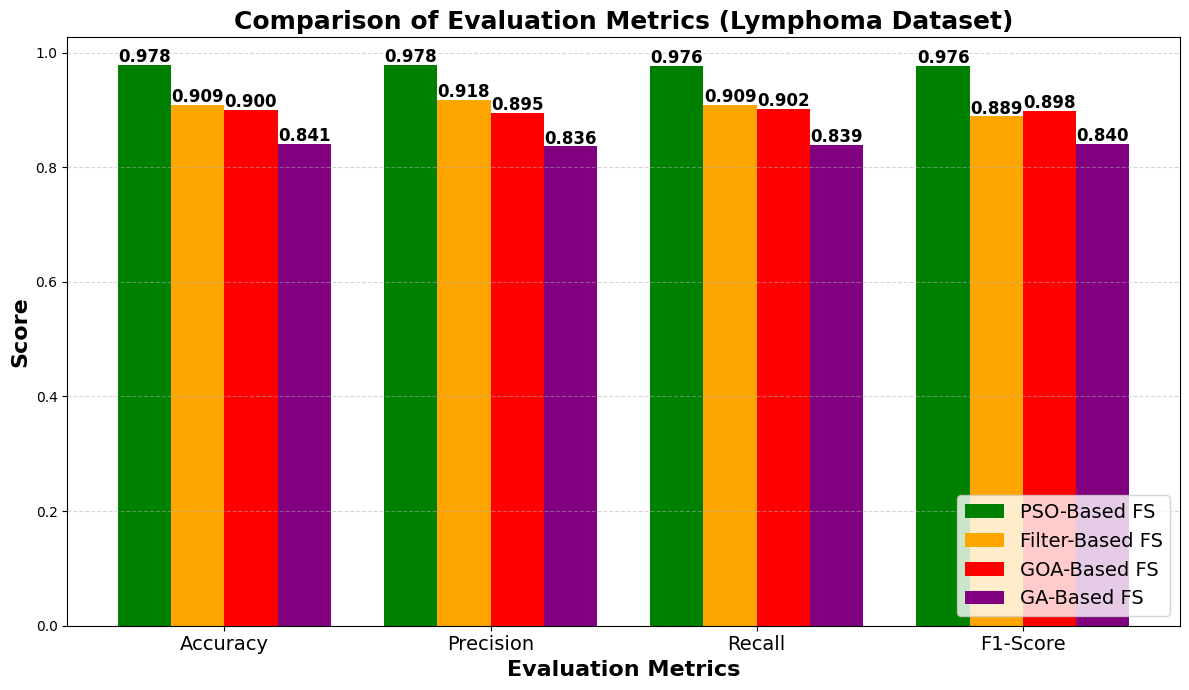

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Evaluation metrics
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]

# Lymphoma dataset results
pso_values = [97.78, 97.78, 97.62, 97.62]
filter_values = [90.91, 91.79, 90.91, 88.87]
goa_values = [90.0, 89.5, 90.2, 89.8]  # Updated GOA FS
ga_values = [84.12, 83.64, 83.86, 84.04]  # GA FS values

# Convert percentages to decimals
pso_values = [val / 100 for val in pso_values]
filter_values = [val / 100 for val in filter_values]
goa_values = [val / 100 for val in goa_values]
ga_values = [val / 100 for val in ga_values]

# Define bar positions and width
x = np.arange(len(metrics)) * 1.5
width = 0.3

# Set figure size
plt.figure(figsize=(12, 7))

# Plot bars
bars1 = plt.bar(x - 1.5 * width, pso_values, width, label="PSO-Based FS", color="green")
bars2 = plt.bar(x - 0.5 * width, filter_values, width, label="Filter-Based FS", color="orange")
bars3 = plt.bar(x + 0.5 * width, goa_values, width, label="GOA-Based FS", color="red")
bars4 = plt.bar(x + 1.5 * width, ga_values, width, label="GA-Based FS", color="purple")

# Labels and title
plt.xlabel("Evaluation Metrics", fontsize=16, fontweight='bold')
plt.ylabel("Score", fontsize=16, fontweight='bold')
plt.title("Comparison of Evaluation Metrics (Lymphoma Dataset)", fontsize=18, fontweight='bold')
plt.xticks(x, metrics, fontsize=14)

# Annotate bars with values
for bars in [bars1, bars2, bars3, bars4]:
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.005,
                 f"{bar.get_height():.3f}", ha='center', fontsize=12, fontweight='bold')

# Add legend
plt.legend(fontsize=14, loc="lower right")

# Show plot
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


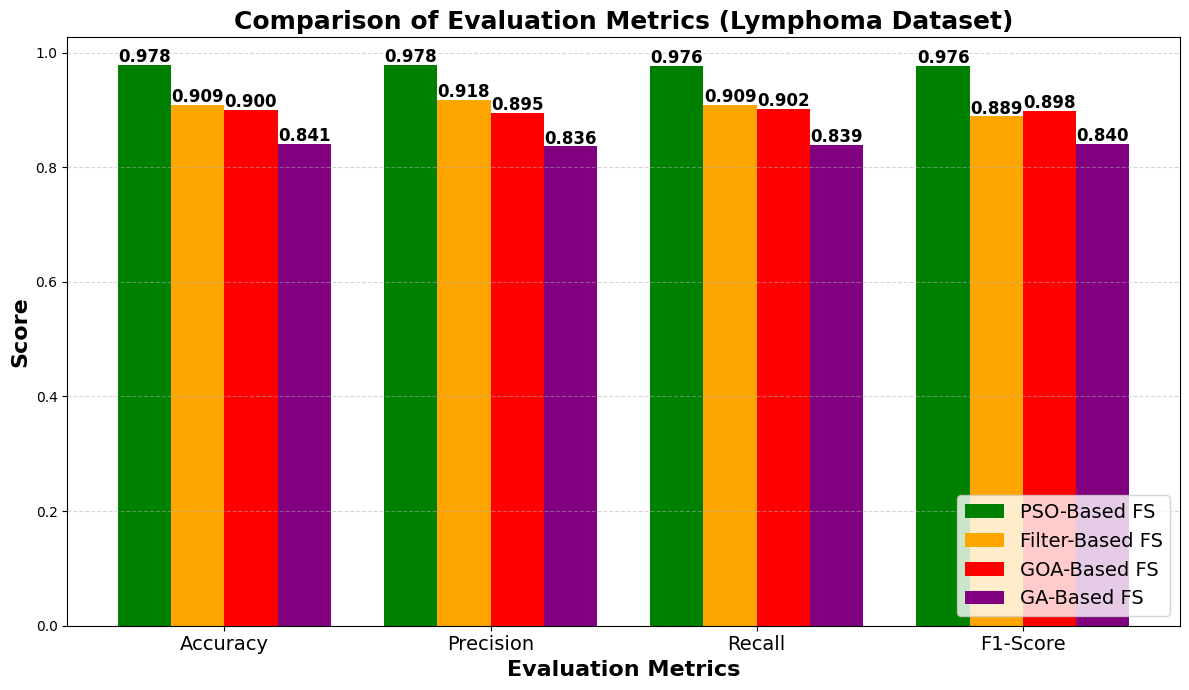

+----------------------------+---------------------+-----------------+------------+-------------+----------+------------+
| Feature Selection Method   |   Selected Features | Reduction (%)   | Accuracy   | Precision   | Recall   | F1-Score   |
+============================+=====================+=================+============+=============+==========+============+
| PSO FS                     |                  13 | 99.68%          | 97.78%     | 97.78%      | 97.62%   | 97.62%     |
+----------------------------+---------------------+-----------------+------------+-------------+----------+------------+
| Filter FS                  |                1668 | 58.57%          | 90.91%     | 91.79%      | 90.91%   | 88.87%     |
+----------------------------+---------------------+-----------------+------------+-------------+----------+------------+
| GOA FS                     |                  27 | 99.33%          | 90.0%      | 89.5%       | 90.2%    | 89.8%      |
+-----------------------

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate

# Evaluation metrics
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]

# Lymphoma dataset results
pso_values = [97.78, 97.78, 97.62, 97.62]
filter_values = [90.91, 91.79, 90.91, 88.87]
goa_values = [90.0, 89.5, 90.2, 89.8]
ga_values = [84.12, 83.64, 83.86, 84.04]

# Normalize values for plotting (convert percentages to decimals)
pso_values_plot = [val / 100 for val in pso_values]
filter_values_plot = [val / 100 for val in filter_values]
goa_values_plot = [val / 100 for val in goa_values]
ga_values_plot = [val / 100 for val in ga_values]

# Bar positions and width
x = np.arange(len(metrics)) * 1.5
width = 0.3

# Create plot
plt.figure(figsize=(12, 7))
bars1 = plt.bar(x - 1.5 * width, pso_values_plot, width, label="PSO-Based FS", color="green")
bars2 = plt.bar(x - 0.5 * width, filter_values_plot, width, label="Filter-Based FS", color="orange")
bars3 = plt.bar(x + 0.5 * width, goa_values_plot, width, label="GOA-Based FS", color="red")
bars4 = plt.bar(x + 1.5 * width, ga_values_plot, width, label="GA-Based FS", color="purple")

# Labels and title
plt.xlabel("Evaluation Metrics", fontsize=16, fontweight='bold')
plt.ylabel("Score", fontsize=16, fontweight='bold')
plt.title("Comparison of Evaluation Metrics (Lymphoma Dataset)", fontsize=18, fontweight='bold')
plt.xticks(x, metrics, fontsize=14)

# Display values on top of bars
for bars in [bars1, bars2, bars3, bars4]:
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.005,
                 f"{bar.get_height():.3f}", ha='center', fontsize=12, fontweight='bold')

plt.legend(fontsize=14, loc="lower right")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# -------------------- TABLE DISPLAY --------------------

# Define evaluation metrics for table
pso_metrics = {"Accuracy": 97.78, "Precision": 97.78, "Recall": 97.62, "F1-Score": 97.62}
filter_metrics = {"Accuracy": 90.91, "Precision": 91.79, "Recall": 90.91, "F1-Score": 88.87}
goa_metrics = {"Accuracy": 90.0, "Precision": 89.5, "Recall": 90.2, "F1-Score": 89.8}
ga_metrics = {"Accuracy": 84.12, "Precision": 83.64, "Recall": 83.86, "F1-Score": 84.04}

# Table data
table_data = [
    ["PSO FS", 13, "99.68%", f"{pso_metrics['Accuracy']}%", f"{pso_metrics['Precision']}%",
     f"{pso_metrics['Recall']}%", f"{pso_metrics['F1-Score']}%"],

    ["Filter FS", 1668, "58.57%", f"{filter_metrics['Accuracy']}%", f"{filter_metrics['Precision']}%",
     f"{filter_metrics['Recall']}%", f"{filter_metrics['F1-Score']}%"],

    ["GOA FS", 27, "99.33%", f"{goa_metrics['Accuracy']}%", f"{goa_metrics['Precision']}%",
     f"{goa_metrics['Recall']}%", f"{goa_metrics['F1-Score']}%"],

    ["GA FS", 32, "99.20%", f"{ga_metrics['Accuracy']}%", f"{ga_metrics['Precision']}%",
     f"{ga_metrics['Recall']}%", f"{ga_metrics['F1-Score']}%"]
]

# Headers
headers = ["Feature Selection Method", "Selected Features", "Reduction (%)",
           "Accuracy", "Precision", "Recall", "F1-Score"]

# Display table
print(tabulate(table_data, headers=headers, tablefmt="grid"))


RESULTS AFTER COMPARISON OF PSO FS WITH OTHER METHODS

<ipython-input-12-637fbc4caa1f>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=methods, y=num_features, palette=colors, edgecolor="black", linewidth=2, width=0.6)


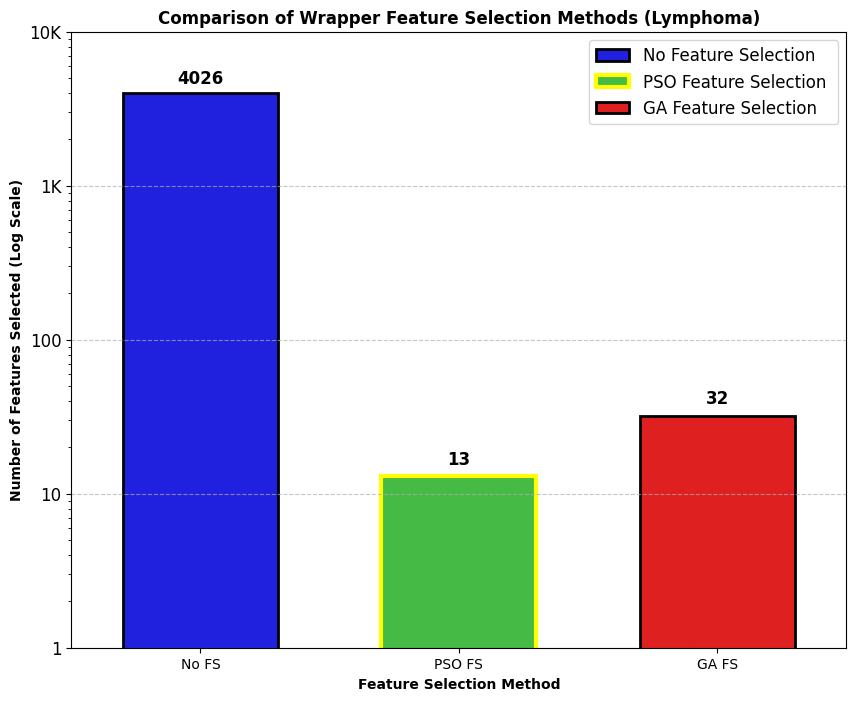

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define feature selection results
methods = ["No FS", "PSO FS", "GA FS"]
num_features = [4026, 13, 32]  # Updated feature counts for Lymphoma dataset
colors = ["blue", "limegreen", "red"]  # Highlight PSO with 'limegreen'

# Increase figure size
plt.figure(figsize=(10, 8))

# Use log scale to make small values more visible
plt.yscale("log")
plt.ylim(1, max(num_features) * 1.5)  # Adjust y-axis for better visibility

# Plot the bar chart with increased bar width
bars = sns.barplot(x=methods, y=num_features, palette=colors, edgecolor="black", linewidth=2, width=0.6)

# Labels and title
plt.xlabel("Feature Selection Method", fontsize=10, fontweight='bold')
plt.ylabel("Number of Features Selected (Log Scale)", fontsize=10, fontweight='bold')
plt.title("Comparison of Wrapper Feature Selection Methods (Lymphoma)", fontsize=12, fontweight='bold')

# Adjust y-axis ticks
plt.yticks([1, 10, 100, 1000, 10000], ["1", "10", "100", "1K", "10K"], fontsize=12)
plt.grid(axis='y', linestyle="--", alpha=0.7)

# Show exact values on bars with better positioning
for bar, value, method in zip(bars.patches, num_features, methods):
    # Adjust vertical position slightly for No FS
    y_offset = 1.15 if method == "No FS" else 1.2
    plt.text(bar.get_x() + bar.get_width() / 2, value * y_offset, str(value),
             ha='center', fontsize=12, fontweight='bold', color="black")

# Highlight PSO and GA bars with a border effect
bars.patches[1].set_edgecolor("yellow")  # PSO FS
bars.patches[1].set_linewidth(3)

# Add legend
legend_labels = [
    "No Feature Selection",
    "PSO Feature Selection ",
    "GA Feature Selection "
]
plt.legend(handles=bars.patches, labels=legend_labels, loc="upper right", fontsize=12)
plt.savefig("Compare Wrapper Number - Lymphoma.png", dpi=300, bbox_inches='tight')
# Show plot
plt.show()


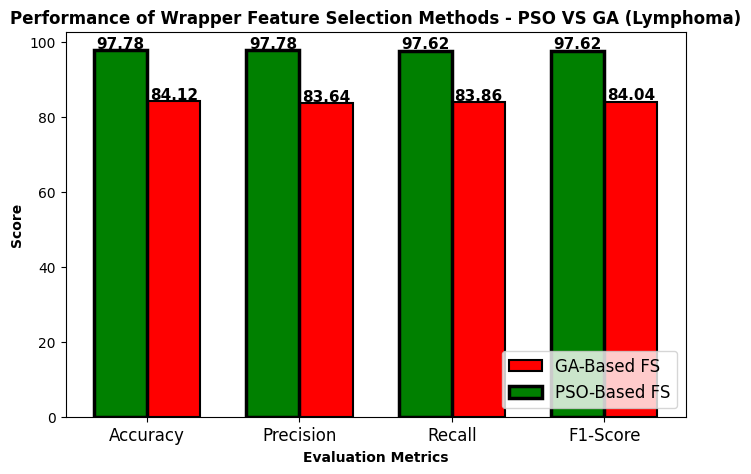

+----------------------------+---------------------+-----------------+------------+-------------+----------+------------+
| Feature Selection Method   |   Selected Features |   Reduction (%) |   Accuracy |   Precision |   Recall |   F1-Score |
+============================+=====================+=================+============+=============+==========+============+
| No FS                      |                4026 |            0    |      91.18 |       91.47 |    91.18 |      91.21 |
+----------------------------+---------------------+-----------------+------------+-------------+----------+------------+
| PSO FS                     |                  13 |           99.68 |      97.78 |       97.78 |    97.62 |      97.62 |
+----------------------------+---------------------+-----------------+------------+-------------+----------+------------+
| GA FS                      |                  32 |           99.2  |      84.12 |       83.64 |    83.86 |      84.04 |
+-----------------------

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate

# Evaluation metrics for PSO FS and GA FS (Lymphoma dataset)
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
pso_values = [97.78, 97.78, 97.62, 97.62]  # PSO FS results
ga_values = [84.12, 83.64, 83.86, 84.04]   # GA FS results

# Bar width and positioning
x = np.arange(len(metrics))
width = 0.35  # Width of bars

# Increase figure size
plt.figure(figsize=(8, 5))

# Plot bars for GA FS and PSO FS
bars2 = plt.bar(x + width/2, ga_values, width, label="GA-Based FS", color="red", edgecolor="black", linewidth=1.5)
bars1 = plt.bar(x - width/2, pso_values, width, label="PSO-Based FS", color="green", edgecolor="black", linewidth=2.5)  # PSO bars with black border

# Labels and title
plt.xlabel("Evaluation Metrics", fontsize=10, fontweight='bold')
plt.ylabel("Score", fontsize=10, fontweight='bold')
plt.title("Performance of Wrapper Feature Selection Methods - PSO VS GA (Lymphoma)", fontsize=12, fontweight='bold')
plt.xticks(x, metrics, fontsize=12)

# Display values on top of bars
for bars in [bars1, bars2]:
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, f"{bar.get_height():.2f}",
                 ha='center', fontsize=11, fontweight='bold')

# Add legend
plt.legend(fontsize=12, loc="lower right")

# Save and show plot
plt.savefig("Compare_Wrapper_Metrics_Lymphoma.png", dpi=300, bbox_inches='tight')
plt.show()

# Define evaluation metrics for No FS, PSO FS, and GA FS (Lymphoma)
no_fs_metrics = {"Accuracy": 91.18, "Precision": 91.47, "Recall": 91.18, "F1-Score": 91.21}
pso_metrics = {"Accuracy": 97.78, "Precision": 97.78, "Recall": 97.62, "F1-Score": 97.62}
ga_metrics = {"Accuracy": 84.12, "Precision": 83.64, "Recall": 83.86, "F1-Score": 84.04}

# Table Data with percentages but no symbol
table_data = [
    ["No FS", 4026, "0", no_fs_metrics["Accuracy"], no_fs_metrics["Precision"],
     no_fs_metrics["Recall"], no_fs_metrics["F1-Score"]],

    ["PSO FS", 13, "99.68", pso_metrics["Accuracy"], pso_metrics["Precision"],
     pso_metrics["Recall"], pso_metrics["F1-Score"]],

    ["GA FS", 32, "99.20", ga_metrics["Accuracy"], ga_metrics["Precision"],
     ga_metrics["Recall"], ga_metrics["F1-Score"]]
]

# Define table headers
headers = ["Feature Selection Method", "Selected Features", "Reduction (%)", "Accuracy", "Precision", "Recall", "F1-Score"]

# Print table with formatted output
print(tabulate(table_data, headers=headers, tablefmt="grid"))


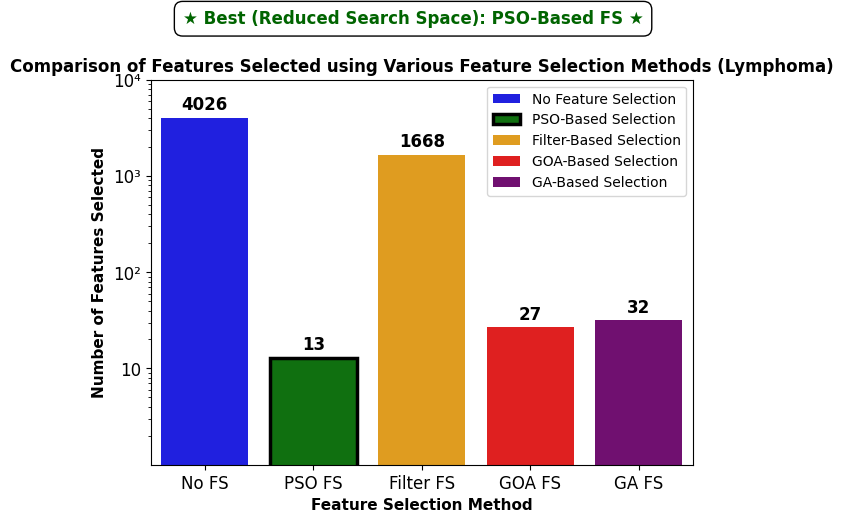

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define feature selection results for Lymphoma dataset
methods = ["No FS", "PSO FS", "Filter FS", "GOA FS", "GA FS"]
num_features = [4026, 13, 1668, 27, 32]  # Updated feature counts
colors = ["blue", "green", "orange", "red", "purple"]

# Increase figure size
fig, ax = plt.subplots(figsize=(7, 5))

# Use log scale for y-axis (set limits from 1 to slightly above 10^4)
plt.yscale("log")
plt.ylim(1, 10**4)

# Plot the bar chart
bars = sns.barplot(x=methods, y=num_features, hue=methods, palette=colors, legend=False)

# Highlight PSO FS (minimum selected features)
for bar, method, value in zip(bars.patches, methods, num_features):
    if method == "PSO FS":
        bar.set_edgecolor("black")  # Add black edge to highlight
        bar.set_linewidth(2.5)  # Make the edge thicker

# Labels and title
plt.xlabel("Feature Selection Method", fontsize=11, fontweight='bold')
plt.ylabel("Number of Features Selected", fontsize=11, fontweight='bold')
plt.title("Comparison of Features Selected using Various Feature Selection Methods (Lymphoma)", fontsize=12, fontweight='bold')

# Adjust tick labels for log scale
plt.xticks(fontsize=12)
plt.yticks([10, 100, 1000, 10000], labels=["10", "10²", "10³", "10⁴"], fontsize=12)

# Show exact values on bars
for bar, value in zip(bars.patches, num_features):
    plt.text(bar.get_x() + bar.get_width() / 2, value * 1.2, str(value),
             ha='center', fontsize=12, fontweight='bold')

# Add legend
legend_labels = ["No Feature Selection", "PSO-Based Selection", "Filter-Based Selection", "GOA-Based Selection", "GA-Based Selection"]
plt.legend(handles=bars.patches, labels=legend_labels, loc="upper right", fontsize=10)

# Annotate PSO FS as the best outside the plot
fig.text(0.5, 1.02,
         "★ Best (Reduced Search Space): PSO-Based FS ★",
         fontsize=12, fontweight='bold', color="darkgreen",
         ha="center", va="top",
         bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.5"))

# Save and show plot
plt.savefig("Compare_FS_Number_Lymphoma.png", dpi=300, bbox_inches='tight')
plt.show()


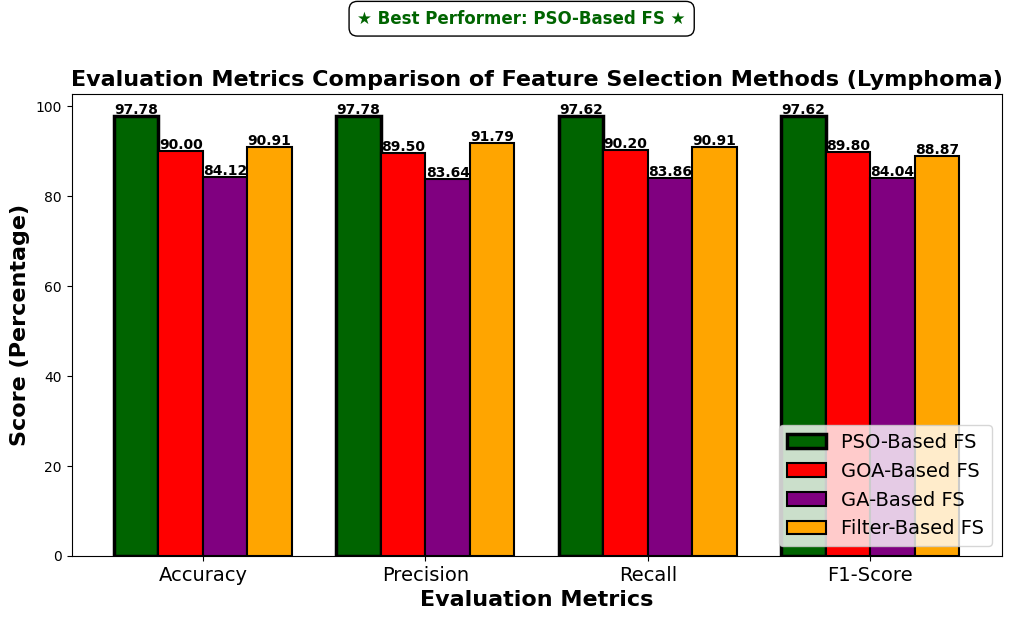

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Updated evaluation metrics for different feature selection methods - Lymphoma dataset
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]

# Updated values for Lymphoma (converted to percentage scale)
pso_values = [97.78, 97.78, 97.62, 97.62]  # PSO FS results
goa_values = [90.00, 89.50, 90.20, 89.80]  # GOA FS results
ga_values = [84.12, 83.64, 83.86, 84.04]   # GA FS results
filter_values = [90.91, 91.79, 90.91, 88.87]  # Filter FS

# Bar width and positioning
x = np.arange(len(metrics))
width = 0.2

# Increase figure size for better visibility
fig, ax = plt.subplots(figsize=(12, 6))

# Define colors
pso_color = "darkgreen"  # Highlight PSO
goa_color = "red"
ga_color = "purple"
filter_color = "orange"

# Plot bars with new order
bars1 = ax.bar(x - 1.5 * width, pso_values, width, label="PSO-Based FS", color=pso_color, edgecolor="black", linewidth=2.5)
bars2 = ax.bar(x - 0.5 * width, goa_values, width, label="GOA-Based FS", color=goa_color, edgecolor="black", linewidth=1.5)
bars3 = ax.bar(x + 0.5 * width, ga_values, width, label="GA-Based FS", color=ga_color, edgecolor="black", linewidth=1.5)
bars4 = ax.bar(x + 1.5 * width, filter_values, width, label="Filter-Based FS", color=filter_color, edgecolor="black", linewidth=1.5)

# Labels and title
ax.set_xlabel("Evaluation Metrics", fontsize=16, fontweight='bold')
ax.set_ylabel("Score (Percentage)", fontsize=16, fontweight='bold')
ax.set_title("Evaluation Metrics Comparison of Feature Selection Methods (Lymphoma)", fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=14)

# Annotate PSO as the best outside the plot
fig.text(0.5, 1.02,
         "★ Best Performer: PSO-Based FS ★",
         fontsize=12, fontweight='bold', color="darkgreen",
         ha="center", va="top", bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.5"))

# Display values on top of bars with reduced font size
for bars in [bars1, bars2, bars3, bars4]:
    for bar in bars:
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, f"{bar.get_height():.2f}",
                ha='center', fontsize=10, fontweight='bold', color="black")  # Reduced font size

# Add legend
ax.legend(fontsize=14, loc="lower right")

# Save and show plot
plt.savefig("Compare_Metrics_Lymphoma.png", dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
from tabulate import tabulate

# Updated evaluation metrics for No FS, PSO FS, Filter FS, GOA FS, and GA FS - Lymphoma dataset
no_fs_metrics = {"Accuracy": 91.18, "Precision": 91.47, "Recall": 91.18, "F1-Score": 91.21}
pso_metrics = {"Accuracy": 97.78, "Precision": 97.78, "Recall": 97.62, "F1-Score": 97.62}
filter_fs_metrics = {"Accuracy": 90.91, "Precision": 91.79, "Recall": 90.91, "F1-Score": 88.87}
goa_metrics = {"Accuracy": 90.0, "Precision": 89.5, "Recall": 90.2, "F1-Score": 89.8}
ga_metrics = {"Accuracy": 84.12, "Precision": 83.64, "Recall": 83.86, "F1-Score": 84.04}

# ANSI escape codes for bold text
bold = "\033[1m"
reset = "\033[0m"

# Updated Table Data (Transposed) - Lymphoma
table_data = [
    ["No FS", 4026, "0%", f"{no_fs_metrics['Accuracy']}%", f"{no_fs_metrics['Precision']}%",
     f"{no_fs_metrics['Recall']}%", f"{no_fs_metrics['F1-Score']}%", ""],

    [f"{bold}PSO FS{reset}", f"{bold}13{reset}", f"{bold}99.68%{reset}", f"{bold}{pso_metrics['Accuracy']}%{reset}",
     f"{bold}{pso_metrics['Precision']}%{reset}", f"{bold}{pso_metrics['Recall']}%{reset}",
     f"{bold}{pso_metrics['F1-Score']}%{reset}", f"{bold}Best Performer{reset}"],

    ["Filter FS", 1668, "58.57%", f"{filter_fs_metrics['Accuracy']}%", f"{filter_fs_metrics['Precision']}%",
     f"{filter_fs_metrics['Recall']}%", f"{filter_fs_metrics['F1-Score']}%", ""],

    ["GOA FS", 27, "99.33%", f"{goa_metrics['Accuracy']}%", f"{goa_metrics['Precision']}%",
     f"{goa_metrics['Recall']}%", f"{goa_metrics['F1-Score']}%", ""],

    ["GA FS", 32, "99.20%", f"{ga_metrics['Accuracy']}%", f"{ga_metrics['Precision']}%",
     f"{ga_metrics['Recall']}%", f"{ga_metrics['F1-Score']}%", ""]
]

# Define table headers
headers = ["Feature Selection Method", "Selected Features", "Reduction (%)", "Accuracy", "Precision", "Recall", "F1-Score", "Best Performer"]

print("\n" + bold + "Comparison of Feature Selection Methods (Lymphoma)" + reset)
print(tabulate(table_data, headers=headers, tablefmt="grid"))



Comparison of Feature Selection Methods (Lymphoma)
+----------------------------+---------------------+-----------------+------------+-------------+----------+------------+------------------+
| Feature Selection Method   |   Selected Features | Reduction (%)   | Accuracy   | Precision   | Recall   | F1-Score   | Best Performer   |
+============================+=====================+=================+============+=============+==========+============+==================+
| No FS                      |                4026 | 0%              | 91.18%     | 91.47%      | 91.18%   | 91.21%     |                  |
+----------------------------+---------------------+-----------------+------------+-------------+----------+------------+------------------+
| PSO FS                     |                  13 | 99.68%          | 97.78%     | 97.78%      | 97.62%   | 97.62%     | Best Performer   |
+----------------------------+---------------------+-----------------+------------+-------------+-----

<ipython-input-8-148408f7037e>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=methods, y=reduction_percentages, palette=colors)


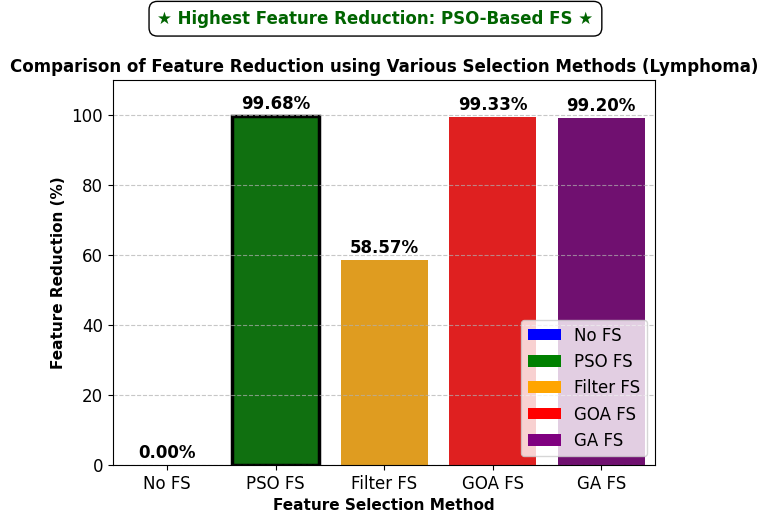

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

# Define feature selection results for Lymphoma dataset
methods = ["No FS", "PSO FS", "Filter FS", "GOA FS", "GA FS"]
reduction_percentages = [0, 99.68, 58.57, 99.33, 99.20]  # Reduction percentages
colors = ["blue", "green", "orange", "red", "purple"]

# Set up the figure
fig, ax = plt.subplots(figsize=(7, 5))
plt.ylim(0, 110)  # y-axis limit

# Plot the bar chart
bars = sns.barplot(x=methods, y=reduction_percentages, palette=colors)

# Highlight the maximum reduction percentage method(s)
max_reduction = max(reduction_percentages)
for bar, method, value in zip(bars.patches, methods, reduction_percentages):
    if value == max_reduction:
        bar.set_edgecolor("black")
        bar.set_linewidth(2.5)

# Labels and title
plt.xlabel("Feature Selection Method", fontsize=11, fontweight='bold')
plt.ylabel("Feature Reduction (%)", fontsize=11, fontweight='bold')
plt.title("Comparison of Feature Reduction using Various Selection Methods (Lymphoma)", fontsize=12, fontweight='bold')

# Show exact values on bars
for bar, value in zip(bars.patches, reduction_percentages):
    plt.text(bar.get_x() + bar.get_width() / 2, value + 2, f"{value:.2f}%", ha='center', fontsize=12, fontweight='bold')

# Add custom legend manually
legend_elements = [
    Patch(facecolor=colors[i], label=methods[i]) for i in range(len(methods))
]
plt.legend(handles=legend_elements, loc="lower right", fontsize=12)

# Annotate best performer
fig.text(0.5, 1.02,
         "★ Highest Feature Reduction: PSO-Based FS ★",
         fontsize=12, fontweight='bold', color="darkgreen",
         ha="center", va="top",
         bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.5"))

# Grid and ticks
plt.grid(axis='y', linestyle="--", alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig("Compare FR - Lymphoma.png", dpi=300, bbox_inches='tight')
# Show plot
plt.show()


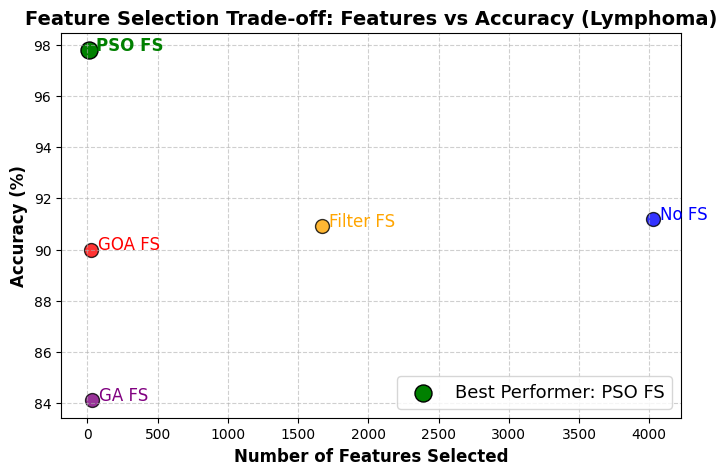

In [ ]:
import matplotlib.pyplot as plt

# Updated data points for Lymphoma (Feature Selection Method, Number of Features, Accuracy)
methods = ["No FS", "PSO FS", "Filter FS", "GOA FS", "GA FS"]
features_selected = [4026, 13, 1668, 27, 32]  # Updated feature counts
accuracy = [91.18, 97.78, 90.91, 90.0, 84.12]  # Updated accuracy values
colors = ["blue", "green", "orange", "red", "purple"]

plt.figure(figsize=(8, 5))

# Scatter plot
for i in range(len(methods)):
    plt.scatter(features_selected[i], accuracy[i], color=colors[i], s=100, edgecolors="black", alpha=0.8)
    # Adjust label styles
    fontweight = 'bold' if methods[i] == "PSO FS" else 'normal'
    plt.text(features_selected[i] + 50, accuracy[i], methods[i], fontsize=12, color=colors[i], fontweight=fontweight)

# Highlight best performer (PSO FS)
best_performer = plt.scatter(features_selected[1], accuracy[1], color="green", s=150, edgecolors="black", label="Best Performer: PSO FS")

# Labels and title
plt.xlabel("Number of Features Selected", fontsize=12, fontweight="bold")
plt.ylabel("Accuracy (%)", fontsize=12, fontweight="bold")
plt.title("Feature Selection Trade-off: Features vs Accuracy (Lymphoma)", fontsize=14, fontweight="bold")

plt.grid(True, linestyle="--", alpha=0.6)

# Add legend at bottom right corner for Best Performer only
plt.legend(handles=[best_performer], loc="lower right", fontsize=13, frameon=True)
plt.savefig("FS Trade-off_Lymphoma.png", dpi=300, bbox_inches='tight')
plt.show()


To Download

In [ ]:
import pandas as pd

# ✅ Updated result table for Lymphoma dataset
results = {
    'Feature Selection Method': ['No FS', 'PSO FS', 'Filter FS', 'GOA FS', 'GA FS'],
    'Selected Features': [4026, 13, 1668, 27, 32],
    'Reduction (%)': ['0%', '99.68%', '58.57%', '99.33%', '99.20%'],
    'Accuracy': ['91.18%', '97.78%', '90.91%', '90.0%', '84.12%'],
    'Precision': ['91.47%', '97.78%', '91.79%', '89.5%', '83.64%'],
    'Recall': ['91.18%', '97.62%', '90.91%', '90.2%', '83.86%'],
    'F1-Score': ['91.21%', '97.62%', '88.87%', '89.8%', '84.04%'],
}

# Convert to DataFrame
df = pd.DataFrame(results)

# Save to CSV
df.to_csv('Lymphoma_results.csv', index=False)

# Show the DataFrame
print(df)


  Feature Selection Method  Selected Features Reduction (%) Accuracy  \
0                    No FS               4026            0%   91.18%   
1                   PSO FS                 13        99.68%   97.78%   
2                Filter FS               1668        58.57%   90.91%   
3                   GOA FS                 27        99.33%    90.0%   
4                    GA FS                 32        99.20%   84.12%   

  Precision  Recall F1-Score  
0    91.47%  91.18%   91.21%  
1    97.78%  97.62%   97.62%  
2    91.79%  90.91%   88.87%  
3     89.5%   90.2%    89.8%  
4    83.64%  83.86%   84.04%  


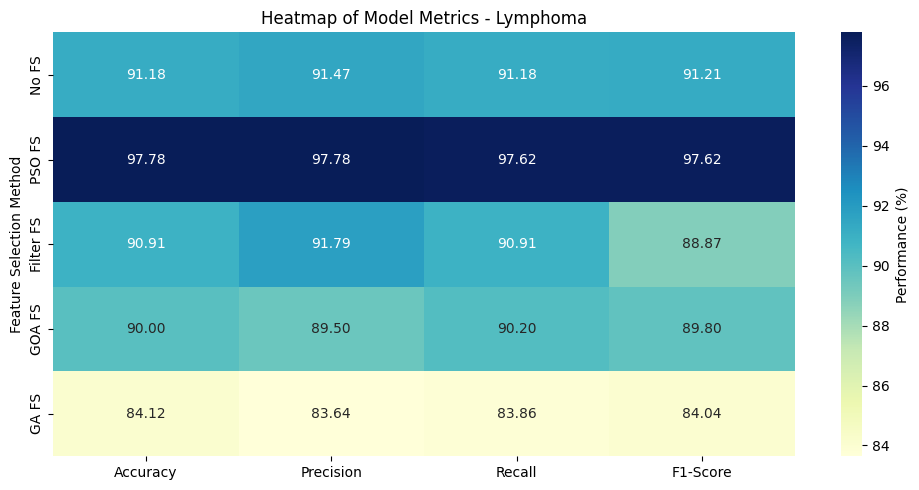

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the CSV
df = pd.read_csv('Lymphoma_results.csv')

# Strip % and convert metric columns to float
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
for col in metrics:
    df[col] = df[col].str.rstrip('%').astype(float)

# Set index for heatmap
heatmap_df = df.set_index('Feature Selection Method')[metrics]

# Plot the heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(heatmap_df, annot=True, fmt=".2f", cmap='YlGnBu', cbar_kws={'label': 'Performance (%)'})
plt.title("Heatmap of Model Metrics - Lymphoma")
plt.tight_layout()
plt.savefig("Lymphoma_FS_Metrics_Heatmap.png", dpi=300, bbox_inches='tight')
plt.show()


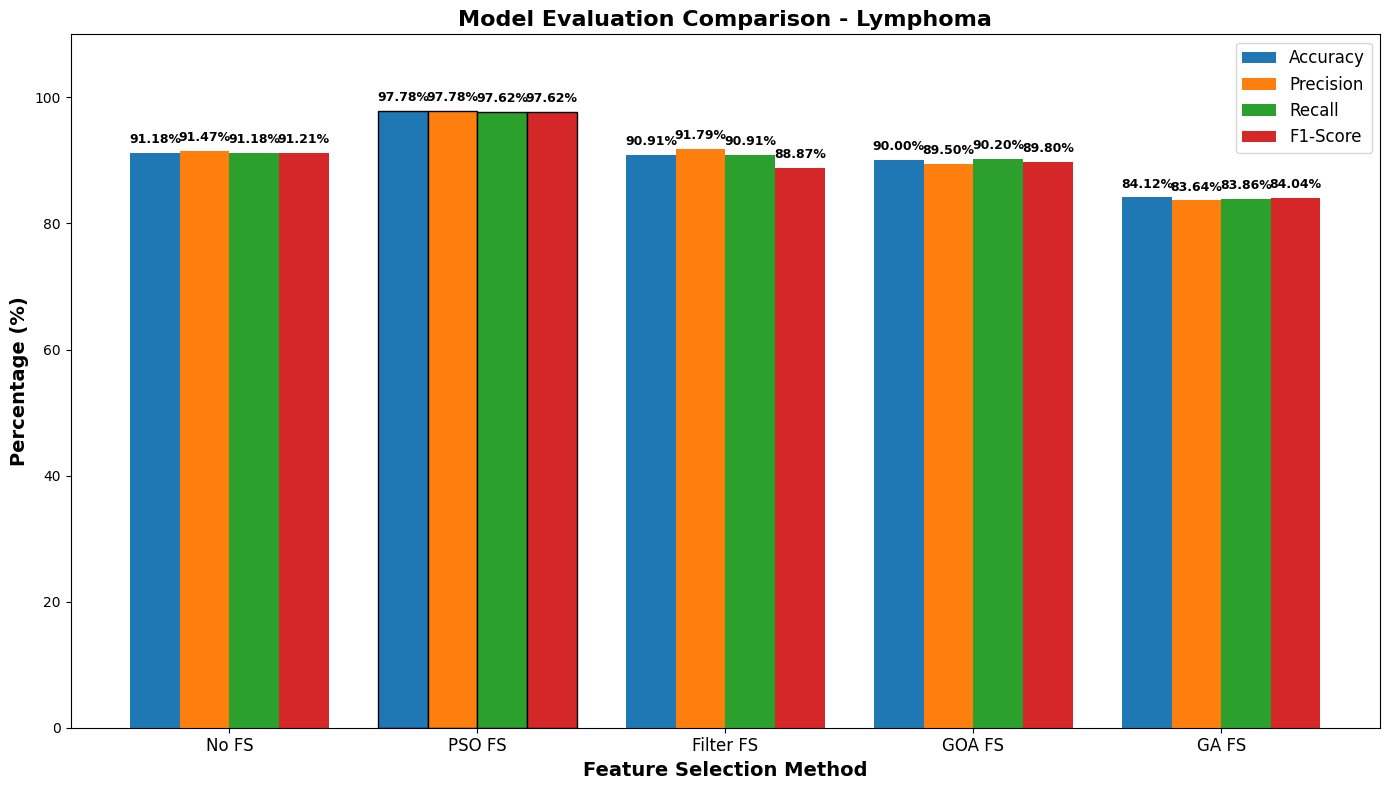

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the results
df = pd.read_csv('Lymphoma_results.csv')

# Convert percentage strings to floats
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
for col in metrics:
    df[col] = df[col].str.rstrip('%').astype(float)

# Plot grouped bar chart
x = np.arange(len(df['Feature Selection Method']))  # the label locations
width = 0.2  # width of each bar

# 📈 Increased figure size
fig, ax = plt.subplots(figsize=(14, 8))

# Identify PSO FS index to highlight its bars
pso_index = df[df['Feature Selection Method'] == 'PSO FS'].index[0]

# Create bars with black edge only for PSO FS
rects1 = ax.bar(x - 1.5*width, df['Accuracy'], width, label='Accuracy',
                edgecolor=['black' if i == pso_index else 'none' for i in range(len(df))])
rects2 = ax.bar(x - 0.5*width, df['Precision'], width, label='Precision',
                edgecolor=['black' if i == pso_index else 'none' for i in range(len(df))])
rects3 = ax.bar(x + 0.5*width, df['Recall'], width, label='Recall',
                edgecolor=['black' if i == pso_index else 'none' for i in range(len(df))])
rects4 = ax.bar(x + 1.5*width, df['F1-Score'], width, label='F1-Score',
                edgecolor=['black' if i == pso_index else 'none' for i in range(len(df))])

# Annotate values on bars
for rect in [rects1, rects2, rects3, rects4]:
    for bar in rect:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 5), textcoords="offset points",
                    ha='center', va='bottom', fontsize=9, fontweight='bold')

# Labels and title (bold)
ax.set_ylabel('Percentage (%)', fontsize=14, fontweight='bold')
ax.set_xlabel('Feature Selection Method', fontsize=14, fontweight='bold')
ax.set_title('Model Evaluation Comparison - Lymphoma', fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(df['Feature Selection Method'], fontsize=12)

# Legend
ax.legend(fontsize=12)
plt.ylim(0, 110)

plt.tight_layout()
plt.savefig("Lymphoma_FS_Metrics_GroupedBar_PSO_Highlighted.png", dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
!ls *.png

'Compare FR - Lymphoma.png'		   GA_Convergence_Lymphoma.png
'Compare FS Number - Lymphoma.png'	   GA_ROC_Lymphoma.png
'Compare Metrics - Lymphoma.png'	   GOA_Confusion_Lymphoma.png
'Compare Wrapper Metrics - Lymphoma.png'   GOA_Convergence_Lymphoma.png
'Compare Wrapper Number - Lymphoma.png'    Lymphoma_FS_Metrics_GroupedBar_PSO_Highlighted.png
 Filter_Convergence_Lymphoma.png	   Lymphoma_FS_Metrics_Heatmap.png
 Filter_ROC_Lymphoma.png		   PSO_Confusion_Lymphoma.png
'FS Trade-off_Lymphoma.png'		   PSO_Convergence_Lymphoma.png
 GA_Confusion_Lymphoma.png		   PSO_ROC_Lymphoma.png


In [ ]:
!mkdir -p Lymphoma_Plots #change based on the dataset


In [ ]:
!ls Lymphoma_Plots

In [ ]:

lymphoma_plots_path = '/content/drive/MyDrive/Lymphoma_Plots'


In [ ]:
!mv *.csv Lymphoma_Plots/

In [ ]:
!mv *.png Lymphoma_Plots/

In [ ]:
!zip -r Lymphoma_Plots.zip Lymphoma_Plots


  adding: Lymphoma_Plots/ (stored 0%)
  adding: Lymphoma_Plots/Compare FR - Lymphoma.png (deflated 15%)
  adding: Lymphoma_Plots/GA_ROC_Lymphoma.png (deflated 17%)
  adding: Lymphoma_Plots/GOA_Convergence_Lymphoma.png (deflated 17%)
  adding: Lymphoma_Plots/GA_Convergence_Lymphoma.png (deflated 22%)
  adding: Lymphoma_Plots/Compare FS Number - Lymphoma.png (deflated 16%)
  adding: Lymphoma_Plots/Lymphoma_FS_Metrics_GroupedBar_PSO_Highlighted.png (deflated 28%)
  adding: Lymphoma_Plots/FS Trade-off_Lymphoma.png (deflated 17%)
  adding: Lymphoma_Plots/Filter_ROC_Lymphoma.png (deflated 19%)
  adding: Lymphoma_Plots/PSO_Confusion_Lymphoma.png (deflated 25%)
  adding: Lymphoma_Plots/GOA_Confusion_Lymphoma.png (deflated 19%)
  adding: Lymphoma_Plots/Compare Metrics - Lymphoma.png (deflated 18%)
  adding: Lymphoma_Plots/Compare Wrapper Number - Lymphoma.png (deflated 23%)
  adding: Lymphoma_Plots/PSO_Convergence_Lymphoma.png (deflated 18%)
  adding: Lymphoma_Plots/Lymphoma_results.csv (deflat

In [ ]:
from google.colab import files
files.download('Lymphoma_Plots.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>